<a href="https://colab.research.google.com/github/plhsu19/Algorithms_Coursera/blob/master/Code/flow_regression_filterd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Simple Regression Model for Traffic Flow Prediction after removing data with low confidence value in INRIX data
This task aims to remove the INRIX data point with low confidence value, and then implement simple regression models (Polynomial, Decision Tree, Random Forest) to predict the traffic flow based on Mcs data and INRIX data

## 0. Environment Setting

### 0.1 Import Libraries & Define Constants

In [0]:
from google.colab import drive
import os
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn
from datetime import datetime


# Constants
SCORE_THRESHOLD = 30
INDEX_2_HEAD_SHIFTED = 1311 # index of head of 2nd Oct for INRIX_south dataset (shifted time)
INDEX_3_HEAD_SHIFTED = 2721 # index of head of 3rd Oct for INRIX_south dataset (shifted time)
INDEX_4_HEAD_SHIFTED = 4148 # index of head of 4th Oct for INRIX_south dataset (shifted time)
INDEX_5_HEAD_SHIFTED = 5570 # index of head of 5th Oct for INRIX_south dataset (shifted time)
INDEX_6_HEAD_SHIFTED = 7001 # index of head of 6th Oct for INRIX_south dataset (shifted time)
INDEX_28_HEAD_SHIFTED = 38407 # index of head of 28 Oct for INRIX_south dataset (shifted time)

INDEX_2_HEAD_REMOVED = 1266 # index of head of 2 Oct for INRIX_south dataset (filtered low score)
INDEX_3_HEAD_REMOVED = 2587 # index of head of 3 Oct for INRIX_south dataset (filtered low score)
INDEX_4_HEAD_REMOVED = 3922 # index of head of 4 Oct for INRIX_south dataset (filtered low score)
INDEX_5_HEAD_REMOVED = 5333 # index of head of 5 Oct for INRIX_south dataset (filtered low score)
INDEX_6_HEAD_REMOVED = 6708 # index of head of 6 Oct for INRIX_south dataset (filtered low score)
INDEX_7_HEAD_REMOVED = 8085 # index of head of 7 Oct for INRIX_south dataset (filtered low score)
INDEX_8_HEAD_REMOVED = 9454 # index of head of 8 Oct for INRIX_south dataset (filtered low score)
INDEX_9_HEAD_REMOVED = 10796 # index of head of 9 Oct for INRIX_south dataset (filtered low score)
INDEX_10_HEAD_REMOVED = 12143 # index of head of 10 Oct for INRIX_south dataset (filtered low score)
INDEX_16_HEAD_REMOVED = 18972 # index of head of 16 Oct for INRIX_south dataset (filtered low score)

INDEX_28_HEAD_REMOVED = 36567 # index of head of 28 Oct for INRIX_south dataset (filtered low score)

### 0.2 Mount Google drive, Set working directory

In [2]:
drive.mount('/content/gdrive')
print(os.path.abspath('.'))
root_path = '/content/gdrive/My Drive/degree_project/' 
os.chdir(root_path + 'Data')
print(os.getcwd())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content
/content/gdrive/My Drive/degree_project/Data


## 1. Import Data


*   mcs north (processed)
*   mcs south (processed)
*   inrix (un-processed)



In [0]:
# import processed mcs datasets(North/South)
mcsNorth = pd.read_csv("OutData/mcsNorth.csv", delimiter = ';')
mcsSouth = pd.read_csv("OutData/mcsSouth.csv", delimiter= ';')

In [0]:
# import un-processed inrix dataset
inrix = pd.read_csv("InData/inrix_225285973_1071883675_oct2018.csv", delimiter= ',')

# 2. Data Preprocessing

## 2.0 Explore and pre-process MCS data

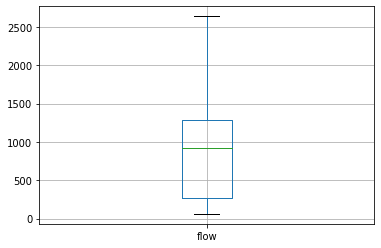

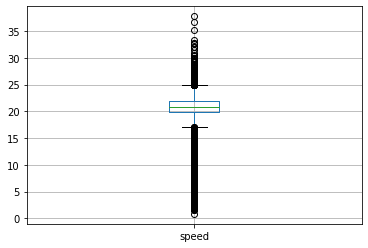

In [5]:
#check the distribution of MCS speed and flow

plt.figure(1)
boxplot1 = mcsSouth.boxplot(column=['flow'])

plt.figure(2)
boxplot2 = mcsSouth.boxplot(column=['speed']) 

## 2.1 Pre-process INRIX data: 

*   transfer units
*   transfer 'registered' to datetime format





In [6]:
inrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89193 entries, 0 to 89192
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   segmentid          89193 non-null  int64  
 1   timestamputc       89193 non-null  object 
 2   segmenttype        89193 non-null  object 
 3   speed              89193 non-null  int64  
 4   average            89193 non-null  int64  
 5   reference          89193 non-null  int64  
 6   traveltimeminutes  89193 non-null  float64
 7   score              89193 non-null  int64  
 8   cvalue             89193 non-null  int64  
 9   speedbucket        89193 non-null  int64  
 10  registered         89193 non-null  object 
dtypes: float64(1), int64(7), object(3)
memory usage: 7.5+ MB


In [7]:
inrix.describe()

segmentid         speed  ...        cvalue   speedbucket
count  8.919300e+04  89193.000000  ...  89193.000000  89193.000000
mean   6.485896e+08     72.411523  ...     76.437512      2.866178
std    4.233012e+08     13.314561  ...     30.278143      0.459020
min    2.252860e+08      6.000000  ...     -1.000000      0.000000
25%    2.252860e+08     68.000000  ...     66.000000      3.000000
50%    1.071884e+09     74.000000  ...     90.000000      3.000000
75%    1.071884e+09     79.000000  ...     99.000000      3.000000
max    1.071884e+09    138.000000  ...    100.000000      3.000000

[8 rows x 8 columns]

In [0]:
# Convert unit of speed from km/s to m/s
transferSpeed = lambda x: x * 1000.0 / 3600.0 

inrix['speed'] = inrix.speed.apply(transferSpeed)
inrix['average'] = inrix.average.apply(transferSpeed)
inrix['reference'] = inrix.reference.apply(transferSpeed)

# Convert unit of travel_time from minute to sec
inrix['travel_time_secs'] = inrix.traveltimeminutes * 60

# drop unnecessary columns
inrix.drop(columns = ['segmenttype', 'traveltimeminutes', 'speedbucket'], inplace=True)

In [9]:
inrix.head(10)

segmentid         timestamputc  ...               registered  travel_time_secs
0  225285973  2018-10-01 00:00:14  ...   2018-10-01 02:00:14.49             19.92
1  225285973  2018-10-01 00:01:12  ...  2018-10-01 02:01:12.193             19.92
2  225285973  2018-10-01 00:02:10  ...   2018-10-01 02:02:10.25             19.92
3  225285973  2018-10-01 00:03:11  ...  2018-10-01 02:03:11.093             19.92
4  225285973  2018-10-01 00:04:11  ...  2018-10-01 02:04:11.653             19.92
5  225285973  2018-10-01 00:05:13  ...  2018-10-01 02:05:13.403             20.34
6  225285973  2018-10-01 00:06:12  ...   2018-10-01 02:06:12.52             20.34
7  225285973  2018-10-01 00:07:10  ...   2018-10-01 02:07:10.75             20.34
8  225285973  2018-10-01 00:08:11  ...  2018-10-01 02:08:11.057             29.88
9  225285973  2018-10-01 00:09:12  ...  2018-10-01 02:09:12.127             29.88

[10 rows x 9 columns]

In [10]:
# strip the unnecessary tail of 'registered
stripTail = lambda x: x.split('.')[0]
inrix['registered'] = inrix.registered.apply(stripTail)

# convert column "registered" into Datetime objects, add into a new column "date_inrix"
convertToDateR = lambda row: datetime.strptime(row['registered'], "%Y-%m-%d %H:%M:%S")
inrix['date_inrix'] = inrix.apply(convertToDateR, axis=1)

# convert column "timestamputc" into Datetime objects, add into original column "timestamputc"
convertToDateU = lambda row: datetime.strptime(row['timestamputc'], "%Y-%m-%d %H:%M:%S")
inrix['timestamputc'] = inrix.apply(convertToDateU, axis=1)

print(inrix.info())
inrix.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89193 entries, 0 to 89192
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   segmentid         89193 non-null  int64         
 1   timestamputc      89193 non-null  datetime64[ns]
 2   speed             89193 non-null  float64       
 3   average           89193 non-null  float64       
 4   reference         89193 non-null  float64       
 5   score             89193 non-null  int64         
 6   cvalue            89193 non-null  int64         
 7   registered        89193 non-null  object        
 8   travel_time_secs  89193 non-null  float64       
 9   date_inrix        89193 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(4), int64(3), object(1)
memory usage: 6.8+ MB
None


segmentid        timestamputc  ...  travel_time_secs          date_inrix
0  225285973 2018-10-01 00:00:14  ...             19.92 2018-10-01 02:00:14
1  225285973 2018-10-01 00:01:12  ...             19.92 2018-10-01 02:01:12
2  225285973 2018-10-01 00:02:10  ...             19.92 2018-10-01 02:02:10
3  225285973 2018-10-01 00:03:11  ...             19.92 2018-10-01 02:03:11
4  225285973 2018-10-01 00:04:11  ...             19.92 2018-10-01 02:04:11
5  225285973 2018-10-01 00:05:13  ...             20.34 2018-10-01 02:05:13
6  225285973 2018-10-01 00:06:12  ...             20.34 2018-10-01 02:06:12
7  225285973 2018-10-01 00:07:10  ...             20.34 2018-10-01 02:07:10
8  225285973 2018-10-01 00:08:11  ...             29.88 2018-10-01 02:08:11
9  225285973 2018-10-01 00:09:12  ...             29.88 2018-10-01 02:09:12

[10 rows x 10 columns]

In [11]:
# drop columns 'registered'
inrix.drop(columns='registered', inplace=True)
inrix.head(5)

segmentid        timestamputc  ...  travel_time_secs          date_inrix
0  225285973 2018-10-01 00:00:14  ...             19.92 2018-10-01 02:00:14
1  225285973 2018-10-01 00:01:12  ...             19.92 2018-10-01 02:01:12
2  225285973 2018-10-01 00:02:10  ...             19.92 2018-10-01 02:02:10
3  225285973 2018-10-01 00:03:11  ...             19.92 2018-10-01 02:03:11
4  225285973 2018-10-01 00:04:11  ...             19.92 2018-10-01 02:04:11

[5 rows x 9 columns]

## 2.2 Split Inrix_South and Inrix_North
    * Split INRIX into South and North dataframe
    * Use new date object to calculate epoch
    * Remove data point with low Confidence score


In [12]:
# Split Inrix South and North
inrixSouth_raw = inrix[inrix.segmentid == 1071883675]
inrixNorth_raw = inrix[inrix.segmentid == 225285973]
inrixSouth_raw.reset_index(drop=True, inplace=True)
inrixNorth_raw.reset_index(drop=True, inplace=True)
print(len(inrixSouth_raw))
print(len(inrixNorth_raw))
print(len(inrix))

44597
44596
89193


In [13]:
inrixSouth_raw[:5]

segmentid        timestamputc  ...  travel_time_secs          date_inrix
0  1071883675 2018-10-01 00:00:12  ...             44.28 2018-10-01 02:00:12
1  1071883675 2018-10-01 00:01:10  ...             44.28 2018-10-01 02:01:10
2  1071883675 2018-10-01 00:02:08  ...             42.90 2018-10-01 02:02:08
3  1071883675 2018-10-01 00:03:09  ...             42.90 2018-10-01 02:03:09
4  1071883675 2018-10-01 00:04:10  ...             42.90 2018-10-01 02:04:10

[5 rows x 9 columns]

In [0]:
# function to calculate Epoch between start timestep and current timestep
# Output: float Epoch (sec)
def calEpoch(dataFrame, colName, i):
  delta = dataFrame.loc[i, colName] - dataFrame.loc[0, colName]
  return delta.total_seconds()

In [15]:
inrixSouth_raw['Epoch_inrix'] = 0.0
inrixNorth_raw['Epoch_inrix'] = 0.0

for i in range(len(inrixSouth_raw)):
  inrixSouth_raw.at[i, 'Epoch_inrix'] = calEpoch(inrixSouth_raw, 'timestamputc', i)

for i in range(len(inrixNorth_raw)):
  inrixNorth_raw.at[i, 'Epoch_inrix'] = calEpoch(inrixNorth_raw, 'timestamputc', i)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
#inrixSouth_raw[inrixSouth_raw.timestamputc == '2018-10-29 00:00:12']
inrixNorth_raw.head(5)

segmentid        timestamputc  ...          date_inrix  Epoch_inrix
0  225285973 2018-10-01 00:00:14  ... 2018-10-01 02:00:14          0.0
1  225285973 2018-10-01 00:01:12  ... 2018-10-01 02:01:12         58.0
2  225285973 2018-10-01 00:02:10  ... 2018-10-01 02:02:10        116.0
3  225285973 2018-10-01 00:03:11  ... 2018-10-01 02:03:11        177.0
4  225285973 2018-10-01 00:04:11  ... 2018-10-01 02:04:11        237.0

[5 rows x 10 columns]

## 2.3 Shift the time-lag of INRIX

In [17]:
# Shift Epoch_inrix of INRIX south by adding 114 mins in order to eliminate the time-gap  
inrixSouth_shifted = inrixSouth_raw.copy()
print(inrixSouth_shifted)
inrixSouth_shifted['Epoch_inrix'] = inrixSouth_shifted.Epoch_inrix + (114 * 60)
print(inrixSouth_shifted)

        segmentid        timestamputc  ...          date_inrix  Epoch_inrix
0      1071883675 2018-10-01 00:00:12  ... 2018-10-01 02:00:12          0.0
1      1071883675 2018-10-01 00:01:10  ... 2018-10-01 02:01:10         58.0
2      1071883675 2018-10-01 00:02:08  ... 2018-10-01 02:02:08        116.0
3      1071883675 2018-10-01 00:03:09  ... 2018-10-01 02:03:09        177.0
4      1071883675 2018-10-01 00:04:10  ... 2018-10-01 02:04:10        238.0
...           ...                 ...  ...                 ...          ...
44592  1071883675 2018-10-31 23:55:12  ... 2018-11-01 00:55:11    2678100.0
44593  1071883675 2018-10-31 23:56:08  ... 2018-11-01 00:56:08    2678156.0
44594  1071883675 2018-10-31 23:57:08  ... 2018-11-01 00:57:08    2678216.0
44595  1071883675 2018-10-31 23:58:09  ... 2018-11-01 00:58:08    2678277.0
44596  1071883675 2018-10-31 23:59:08  ... 2018-11-01 00:59:08    2678336.0

[44597 rows x 10 columns]
        segmentid        timestamputc  ...          date_inri

## 2.4 Match the MCS and INRIX data rows in the same timesteps


In [0]:
# function to match inrix timesteps to mcs, and merge them
# Input: mcs dataframe, inrix dataframe
# output: return a new dataframe combines both dataframes after the time-step matching
def matchTimeStep (mcsDf, inrixDf):
  DELTATIME = 26.0
  mcsMatched = pd.DataFrame(columns = mcsDf.columns)
  inrixMatched = pd.DataFrame(columns = inrixDf.columns)
  print(mcsMatched)
  print(inrixMatched)
  i = 0
  j = 0
  while ((j < len(inrixDf)) & (i < len(mcsDf))):
    mcsEpoch = mcsDf.iloc[i]['Epoch_mcs']
    inrixEpoch = inrixDf.iloc[j]['Epoch_inrix']
    # if the difference in epoch between mcs and inrix is smaller than 25 sec,
    # they are in the same time step (within same min interval)
    if (abs(inrixEpoch - mcsEpoch) < DELTATIME ):
      mcsMatched = mcsMatched.append(mcsDf.iloc[i], ignore_index = True)
      inrixMatched = inrixMatched.append(inrixDf.iloc[j], ignore_index = True)
      i += 1
      j += 1
      if(i % 1000.0 == 0): print(mcsMatched)
    elif ((inrixEpoch - mcsEpoch) < 0.0):
      j += 1
      print('missing mcs', j)
    elif ((inrixEpoch -mcsEpoch) > 0.0):
      i +=1
      print('missing inrix', i)
  
  print('length of mcsMatched: ', len(mcsMatched))
  print('length of inrixMatched: ', len(inrixMatched))

  print(inrixMatched.columns)
  inrixMatched.rename(columns = {'speed': 'speed_inrix'}, inplace = True)
  print(inrixMatched.columns)
  
  combinedDf = pd.concat([mcsMatched, inrixMatched], axis=1)
  print('length of combined df:', len(combinedDf))
  
  return combinedDf
  

In [19]:
# match the shifted inrix with mcs dataframe and combined them
# Notice: a lot of log will be printed out for progress monitoring 
combinedSouth_shifted = matchTimeStep(mcsSouth, inrixSouth_shifted)

Empty DataFrame
Columns: [fk_id, date, speed, speed_std_dev, flow, used_lanes, Epoch_mcs, Density]
Index: []
Empty DataFrame
Columns: [segmentid, timestamputc, speed, average, reference, score, cvalue, travel_time_secs, date_inrix, Epoch_inrix]
Index: []
missing inrix 1
missing inrix 2
missing inrix 3
missing inrix 4
missing inrix 5
missing inrix 6
missing inrix 7
missing inrix 8
missing inrix 9
missing inrix 10
missing inrix 11
missing inrix 12
missing inrix 13
missing inrix 14
missing inrix 15
missing inrix 16
missing inrix 17
missing inrix 18
missing inrix 19
missing inrix 20
missing inrix 21
missing inrix 22
missing inrix 23
missing inrix 24
missing inrix 25
missing inrix 26
missing inrix 27
missing inrix 28
missing inrix 29
missing inrix 30
missing inrix 31
missing inrix 32
missing inrix 33
missing inrix 34
missing inrix 35
missing inrix 36
missing inrix 37
missing inrix 38
missing inrix 39
missing inrix 40
missing inrix 41
missing inrix 42
missing inrix 43
missing inrix 44
missin

In [20]:
combinedSouth_shifted[['date', 'speed', 'Epoch_mcs', 'timestamputc', 'speed_inrix', 'Epoch_inrix']].iloc[:38557]

date    speed  ...  speed_inrix Epoch_inrix
0      2018-10-01 01:54:00  20.9483  ...    25.833333      6840.0
1      2018-10-01 01:55:00  24.9584  ...    25.833333      6898.0
2      2018-10-01 01:56:00  21.4381  ...    26.944444      6956.0
3      2018-10-01 01:57:00  22.2112  ...    26.944444      7017.0
4      2018-10-01 01:58:00  21.9863  ...    26.944444      7078.0
...                    ...      ...  ...          ...         ...
38552  2018-10-28 02:25:00  23.5543  ...    20.555556   2341497.0
38553  2018-10-28 02:26:00  22.3846  ...    18.888889   2345157.0
38554  2018-10-28 02:27:00  23.0723  ...    18.888889   2345217.0
38555  2018-10-28 02:28:00  22.8486  ...    18.888889   2345278.0
38556  2018-10-28 02:29:00  23.0519  ...    18.888889   2345338.0

[38557 rows x 6 columns]

In [21]:
# Check the datatype after combining, cast the datatypes to the original types
print(combinedSouth_shifted.info())
print(mcsSouth.info())
print(inrixSouth_shifted.info())
combinedSouth_shifted = combinedSouth_shifted.astype({'fk_id':'int64', 'flow':'int64', 
                                                      'segmentid':'int64', 'Epoch_inrix':'int64', 
                                                      'score': 'int64', 'cvalue': 'int64'})
combinedSouth_shifted.info()
combinedSouth_shifted.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44106 entries, 0 to 44105
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   fk_id             44106 non-null  object        
 1   date              44106 non-null  object        
 2   speed             44106 non-null  float64       
 3   speed_std_dev     44106 non-null  float64       
 4   flow              44106 non-null  object        
 5   used_lanes        44106 non-null  object        
 6   Epoch_mcs         44106 non-null  float64       
 7   Density           44106 non-null  float64       
 8   segmentid         44106 non-null  object        
 9   timestamputc      44106 non-null  datetime64[ns]
 10  speed_inrix       44106 non-null  float64       
 11  average           44106 non-null  float64       
 12  reference         44106 non-null  float64       
 13  score             44106 non-null  object        
 14  cvalue            4410

fk_id                 date  ...          date_inrix  Epoch_inrix
0   1162  2018-10-01 01:54:00  ... 2018-10-01 02:00:12         6840
1   1162  2018-10-01 01:55:00  ... 2018-10-01 02:01:10         6898
2   1162  2018-10-01 01:56:00  ... 2018-10-01 02:02:08         6956

[3 rows x 18 columns]

## 2.5 Check the result of data steps shifting & matching

In [22]:
# check the statistical overview
combinedSouth_shifted.describe()

fk_id         speed  ...  travel_time_secs   Epoch_inrix
count  44106.0  44106.000000  ...      44106.000000  4.410600e+04
mean    1162.0     20.337247  ...         58.823412  1.342393e+06
std        0.0      3.358625  ...         18.291256  7.713675e+05
min     1162.0      0.833333  ...         29.820000  6.840000e+03
25%     1162.0     19.959925  ...         51.480000  6.742912e+05
50%     1162.0     20.904250  ...         54.900000  1.341326e+06
75%     1162.0     21.940275  ...         58.860000  2.008902e+06
max     1162.0     37.777800  ...        457.560000  2.681637e+06

[8 rows x 14 columns]

In [0]:
# function to plot 1 attributes (vs. Epochs) from 1 sensor
def plotAttr(days, dataFrame, attribute, sensor_name):
  plt.style.use('default')
  plt.plot(dataFrame['Epoch_mcs'], dataFrame[attribute], 'r', linewidth = 0.8, label = sensor_name)
  plt.xlabel('Epochs(sec)', fontsize= 14)
  plt.xticks(fontsize=14)
  plt.ylabel(attribute, fontsize=14)
  plt.yticks(fontsize=14)
  plt.title(attribute + ' vs. time (' + str(days) + ' day)', fontsize = 18)
  plt.legend()
  plt.show()

In [0]:
# function to plot 2 attributes (vs. Epochs) from 2 different senesors in a same diagram
def plot2Attr(days, dataFrame, attribute1, attribute2, location):
  plt.style.use('default')
  plt.plot(dataFrame['Epoch_mcs'], dataFrame[attribute1], 'r',linewidth = 0.8, label = 'mcs_' + location)
  plt.plot(dataFrame['Epoch_mcs'], dataFrame[attribute2], 'b', linewidth = 0.8, label = 'inrix_' + location)
  plt.xlabel('Epochs(sec)', fontsize= 14)
  plt.xticks(fontsize=14)
  plt.ylabel(attribute1, fontsize=14)
  plt.yticks(fontsize=14)
  plt.title(attribute1 + ' vs. time (' + str(days) + ' day)', fontsize = 14)
  plt.legend()
  plt.show()

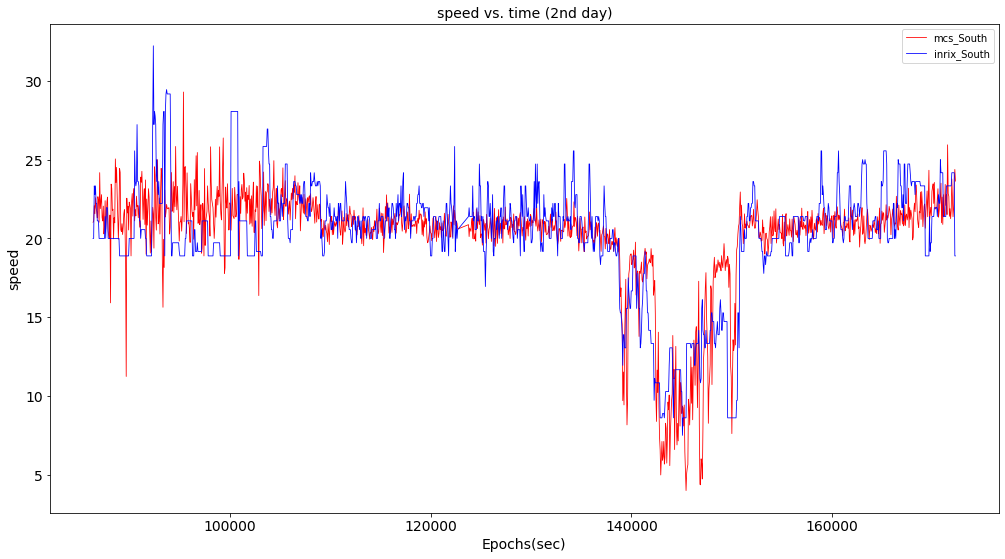

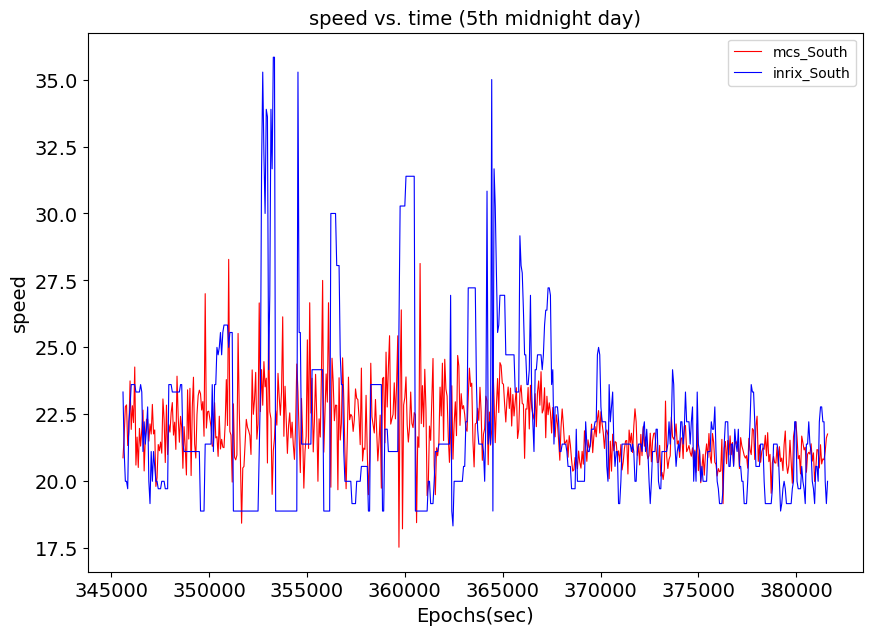

In [24]:
combinedSouthT_shifted = combinedSouth_shifted.iloc[INDEX_2_HEAD_SHIFTED:INDEX_3_HEAD_SHIFTED] 
plt.figure(figsize=(17, 9))
plot2Attr('2nd', combinedSouthT_shifted, 'speed', 'speed_inrix', 'South')

plt.figure(figsize=(10, 7))
combinedSouth3days_shifted = combinedSouth_shifted.iloc[INDEX_5_HEAD_SHIFTED :6169]
plot2Attr('5th midnight', combinedSouth3days_shifted, 'speed', 'speed_inrix', 'South')

In [0]:
def plotScatter(data1, data2, attribute1, attribute2, Label):
  plt.scatter(data1[attribute1], data2[attribute2], s=1.5, label=Label)
  plt.xlabel(attribute1, fontsize = 15)
  plt.xticks(fontsize = 14)
  plt.yticks(fontsize = 14)
  plt.ylabel(attribute2, fontsize = 15)
  plt.title(attribute2 + '  vs. ' + attribute1, fontsize = 20)
  plt.legend()
  plt.show()

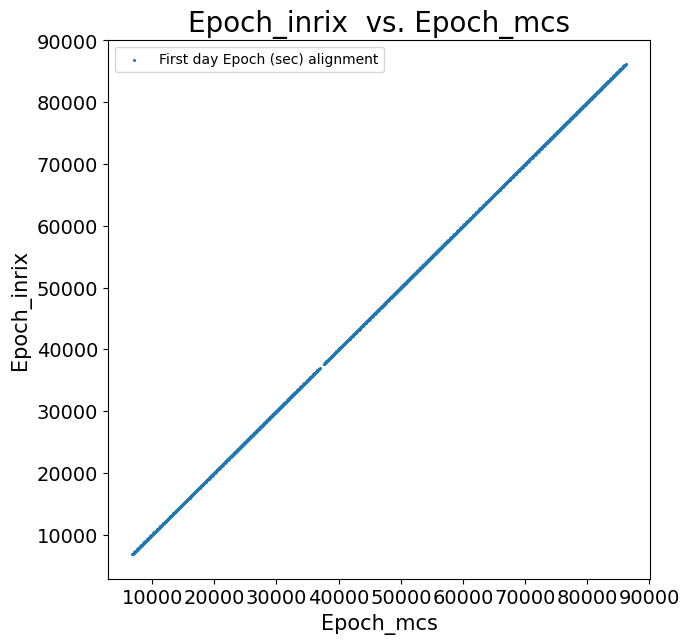

In [26]:
# draw plot of epoch_mcs vs. epoch_inrix after shifting
plt.figure(figsize = (7, 7))
combinedSouth1day_shifted = combinedSouth_shifted.iloc[:INDEX_2_HEAD_SHIFTED]
plotScatter(combinedSouth1day_shifted, combinedSouth1day_shifted, 'Epoch_mcs', 'Epoch_inrix','First day Epoch (sec) alignment')

             speed_inrix     speed
speed_inrix     1.000000  0.720475
speed           0.720475  1.000000


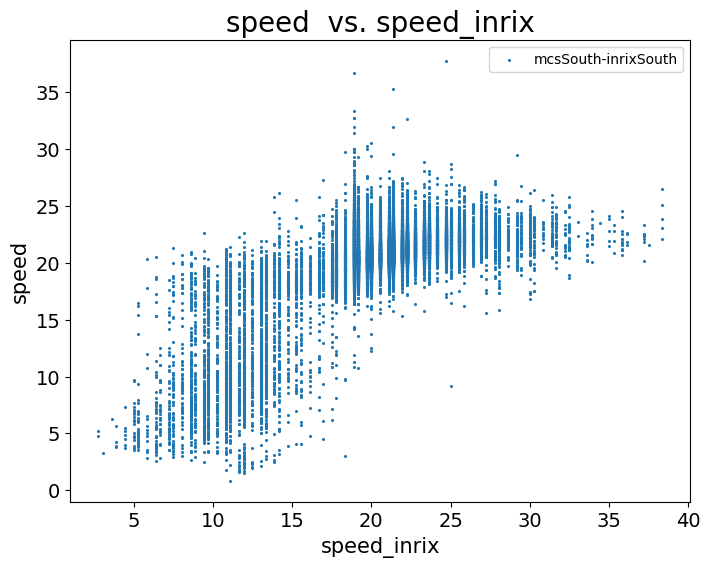

In [27]:
# draw plot of Speed_mcs vs. Speed_inrix after timestep matching
combinedCorr1 = combinedSouth_shifted.iloc[:INDEX_28_HEAD_SHIFTED][['speed_inrix', 'speed']].copy() 
print(combinedCorr1.corr())

plt.figure(figsize=(8,6))
plotScatter(combinedCorr1, combinedCorr1, 'speed_inrix', 'speed', 'mcsSouth-inrixSouth')

             speed_inrix      flow
speed_inrix     1.000000 -0.451633
flow           -0.451633  1.000000


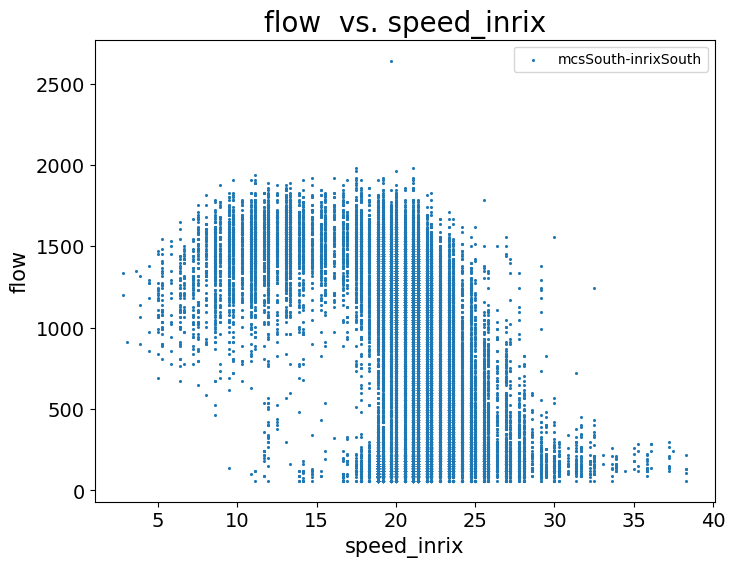

In [28]:
# draw flow_mcs vs. Speed_inrix after time step matched
combinedCorr2 = combinedSouth_shifted.iloc[:INDEX_28_HEAD_SHIFTED][['speed_inrix', 'flow']].copy() # until 27th Oct
print(combinedCorr2.corr())

plt.figure(figsize=(8,6))
plotScatter(combinedCorr2, combinedCorr2, 'speed_inrix', 'flow', 'mcsSouth-inrixSouth')

## 2.6 Check and remove the rows with low (confidence) scores

In [0]:
# function used to get the index of a first timestamp of certain day
def idx(dataFrame, date):
  
  index = 0
  if(date < 10):
    index = dataFrame[dataFrame.date == ('2018-10-0' + str(date) + ' 00:00:00')].index.values[0]
  else:
    index = dataFrame[dataFrame.date == ('2018-10-' + str(date) + ' 00:00:00')].index.values[0]

  return index

In [30]:
# Check the dataset with high score and low score
inrixSouthHighScore = combinedSouth_shifted[combinedSouth_shifted.score >= 30]
inrixSouthMedScore = combinedSouth_shifted[(combinedSouth_shifted.score < 30) & (combinedSouth_shifted.score >= 20)]
inrixSouthLowScore = combinedSouth_shifted[combinedSouth_shifted.score < 20]

print(inrixSouthLowScore.speed_inrix.value_counts()) # almost all are reference speed
print(inrixSouthMedScore.speed_inrix.value_counts()) # almost all are reference speed


# check MSE between speed_mcs and speed_inrix
deltaSpeedH = inrixSouthHighScore.speed - inrixSouthHighScore.speed_inrix
deltaSpeedM = inrixSouthMedScore.speed - inrixSouthMedScore.speed_inrix
deltaSpeedL = inrixSouthLowScore.speed - inrixSouthLowScore.speed_inrix

absDeltaH = deltaSpeedH.apply(abs)
absDeltaM = deltaSpeedM.apply(abs)
absDeltaL = deltaSpeedL.apply(abs)

print(absDeltaH.mean())
print(absDeltaM.mean())
print(absDeltaL.mean())

18.888889    2013
Name: speed_inrix, dtype: int64
19.722222    38
19.166667    30
20.000000    26
20.555556     5
18.333333     5
21.388889     2
Name: speed_inrix, dtype: int64
1.773519325592833
2.6426969601677164
3.604788055417571


In [0]:
# remove INRIX data points with low score
combinedSouth_s_r = combinedSouth_shifted[combinedSouth_shifted.score >= SCORE_THRESHOLD]
combinedSouth_s_r.reset_index(drop=True, inplace=True)

In [32]:
print(len(combinedSouth_s_r))
print(combinedSouth_s_r.score.value_counts())

41987
30    41987
Name: score, dtype: int64


In [33]:
combinedSouth_s_r.describe()

fk_id         speed  ...  travel_time_secs   Epoch_inrix
count  41987.0  41987.000000  ...      41987.000000  4.198700e+04
mean    1162.0     20.232405  ...         58.742435  1.341763e+06
std        0.0      3.383300  ...         18.743020  7.718708e+05
min     1162.0      0.833333  ...         29.820000  6.840000e+03
25%     1162.0     19.909050  ...         51.480000  6.715465e+05
50%     1162.0     20.849900  ...         54.180000  1.339976e+06
75%     1162.0     21.842250  ...         58.020000  2.011227e+06
max     1162.0     37.777800  ...        457.560000  2.681637e+06

[8 rows x 14 columns]

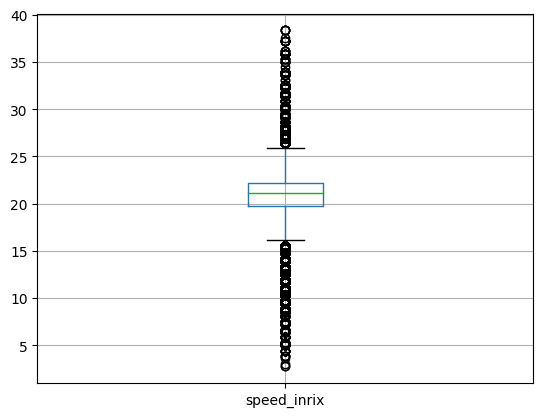

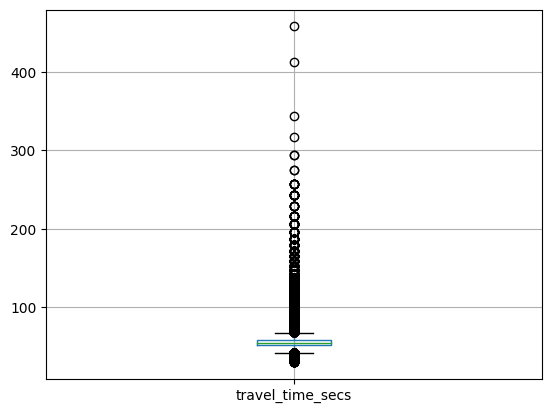

In [34]:
# check distribution of speed_inrix and tracel_time_secs after remove low score data

plt.figure(1)
boxplot = combinedSouth_s_r.boxplot(column=['speed_inrix'])

plt.figure(2)
boxplot = combinedSouth_s_r.boxplot(column=['travel_time_secs'])

             speed_inrix     speed
speed_inrix     1.000000  0.750319
speed           0.750319  1.000000


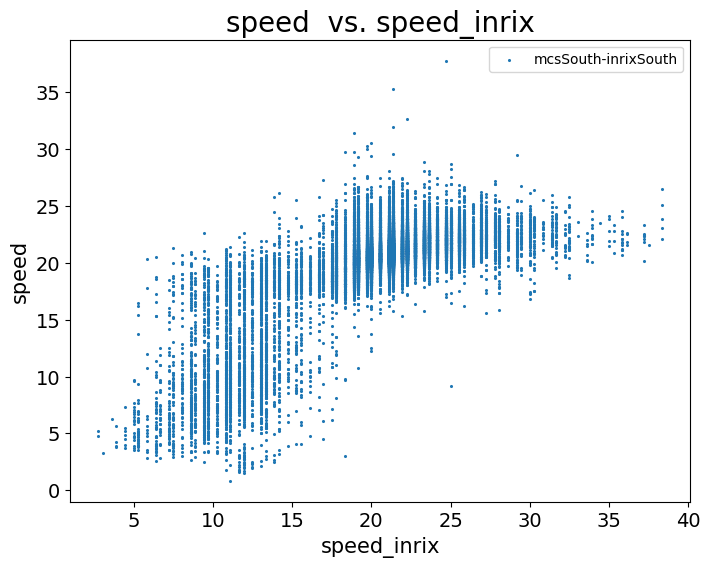

In [35]:
# draw plot of Speed_mcs vs. Speed_inrix after timestep matching
combinedCorr1 = combinedSouth_s_r.iloc[:idx(combinedSouth_s_r, 28)][['speed_inrix', 'speed']].copy() 
print(combinedCorr1.corr())

plt.figure(figsize=(8,6))
plotScatter(combinedCorr1, combinedCorr1, 'speed_inrix', 'speed', 'mcsSouth-inrixSouth')

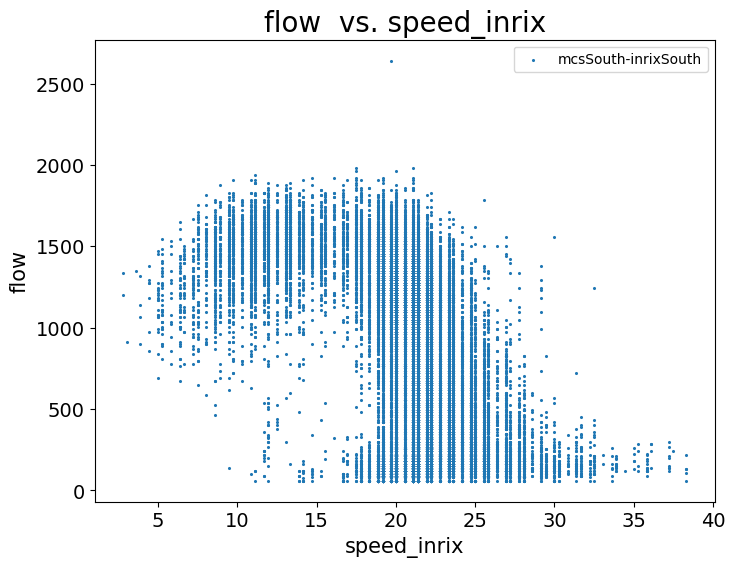

In [36]:
# draw flow_mcs vs. Speed_inrix after removal of low score
combinedCorr2 = combinedSouth_s_r.iloc[:idx(combinedSouth_s_r, 28)][['speed_inrix', 'flow']].copy() # until 27th Oct

plt.figure(figsize=(8,6))
plotScatter(combinedCorr2, combinedCorr2, 'speed_inrix', 'flow', 'mcsSouth-inrixSouth')

In [37]:
combinedSouth_s_r['date'].iloc[INDEX_10_HEAD_REMOVED + INDEX_6_HEAD_REMOVED + 100  : INDEX_10_HEAD_REMOVED + INDEX_6_HEAD_REMOVED + 150]

18951    2018-10-14 23:30:00
18952    2018-10-14 23:31:00
18953    2018-10-14 23:32:00
18954    2018-10-14 23:33:00
18955    2018-10-14 23:34:00
18956    2018-10-14 23:35:00
18957    2018-10-14 23:36:00
18958    2018-10-14 23:37:00
18959    2018-10-14 23:38:00
18960    2018-10-14 23:39:00
18961    2018-10-14 23:40:00
18962    2018-10-14 23:41:00
18963    2018-10-14 23:42:00
18964    2018-10-14 23:43:00
18965    2018-10-14 23:44:00
18966    2018-10-14 23:45:00
18967    2018-10-14 23:46:00
18968    2018-10-14 23:47:00
18969    2018-10-14 23:48:00
18970    2018-10-14 23:49:00
18971    2018-10-14 23:50:00
18972    2018-10-15 00:00:00
18973    2018-10-15 00:08:00
18974    2018-10-15 00:09:00
18975    2018-10-15 00:10:00
18976    2018-10-15 00:11:00
18977    2018-10-15 00:12:00
18978    2018-10-15 00:13:00
18979    2018-10-15 00:14:00
18980    2018-10-15 00:15:00
18981    2018-10-15 00:25:00
18982    2018-10-15 00:26:00
18983    2018-10-15 00:27:00
18984    2018-10-15 00:28:00
18985    2018-

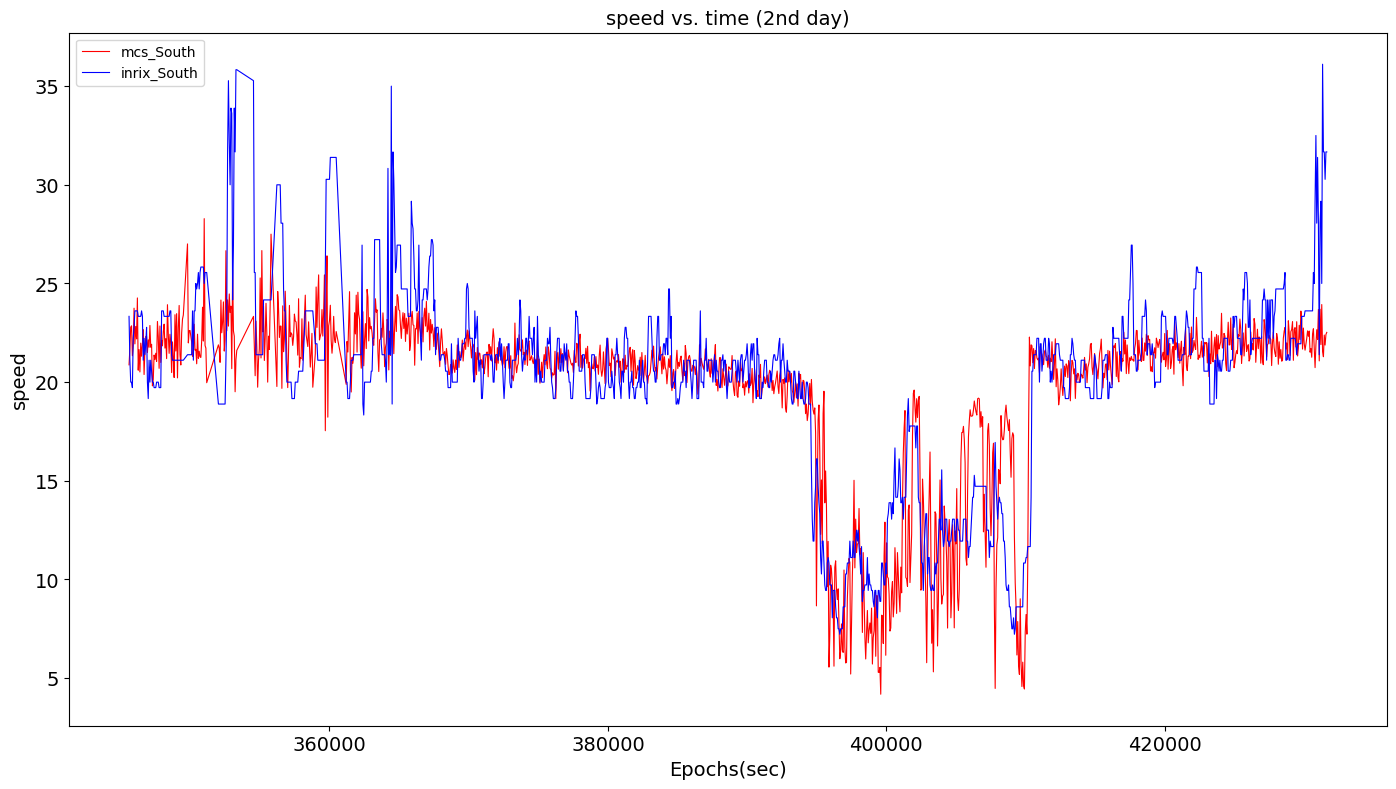

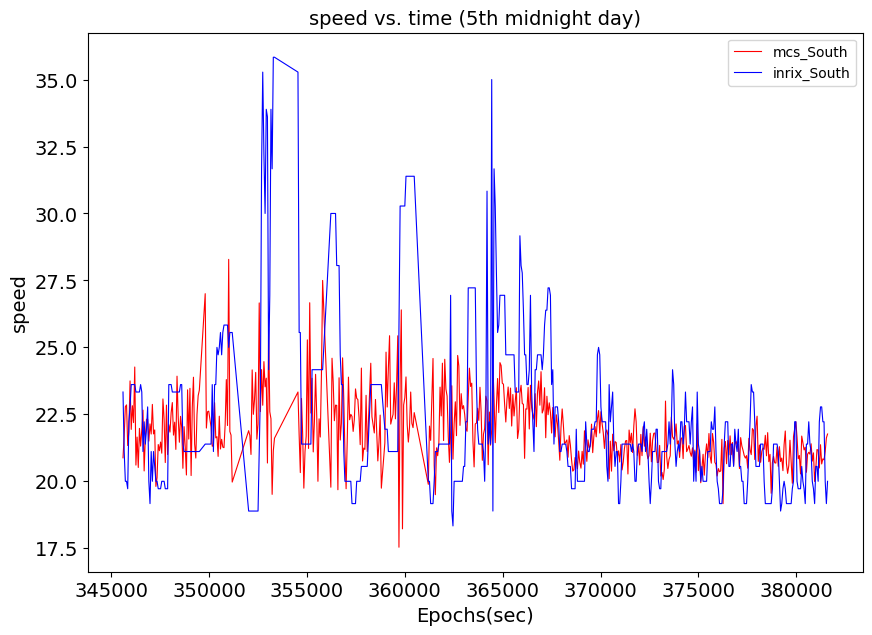

In [38]:
combinedSouthT_s_r = combinedSouth_s_r.iloc[idx(combinedSouth_s_r, 5):idx(combinedSouth_s_r, 6)] 
plt.figure(figsize=(17, 9))
plot2Attr('2nd', combinedSouthT_s_r, 'speed', 'speed_inrix', 'South')

plt.figure(figsize=(10, 7))
combinedSouthMultiDays_s_r = combinedSouth_s_r.iloc[idx(combinedSouth_s_r, 5) :5876]
plot2Attr('5th midnight', combinedSouthMultiDays_s_r, 'speed', 'speed_inrix', 'South')

# 3. Linear (Polynomial) Regression Models
  Use linear (polynomial) regression model to capture the relation between speed/travel time and MCS flow/denstiy

*   Ground Truth Model: Mcs speed -> Mcs Flow ( or Density)
*   INRIX speed -> MCS Flow



## 3.0 Function to plot fitting results on test and train datasets

In [0]:
# function to plot the predicted value and real label value according to training/testing dataset
def plotResult(xTrain, yTrain, yPredTrain, xTest, yTest, yPredTest, timeRange, xLabel, yLabel, plotStyle = 's'):
  if (xTest is not None):
    plt.scatter(xTrain, yTrain, s=3, color='black', label='real flow(train_set)')
    plt.scatter(xTrain, yPredTrain, s= 25, color='blue', marker = "s", label='predicted flow(train_set)')
    plt.scatter(xTest, yTest, color='red', s=3, label='real flow(test_set)')
    plt.scatter(xTest, yPredTest, color='green', s=25, marker = 's', label='predicted flow(test_set)')
  elif (plotStyle == 'p'):
    plt.plot(xTrain, yPredTrain, linewidth=0.5, color='blue', linestyle = 'dashed', label='predicted flow', zorder= 0)
    plt.scatter(xTrain, yTrain, s=3, color='red', label='real flow', zorder= 10)
  elif (plotStyle == 's'):
    plt.scatter(xTrain, yTrain, s = 3, color='green', label='real flow(train_set)')
    plt.scatter(xTrain, yPredTrain, s= 25, color='red', marker = "s", label='predicted flow(train_set)')

  plt.xlabel(xLabel, fontsize= 20) 
  plt.xticks(fontsize = 15)
  plt.ylabel(yLabel, fontsize=20)
  plt.yticks(fontsize = 15)
  plt.title('Regression model for estimation of ' + yLabel + ' in ' + timeRange, fontsize= 14)
  plt.legend(fontsize=14)
  plt.show()

## 3.1 Reference model: MCS Speed -> MCS FLow

In [0]:
# function for turning single feature into polynomial feature columns 
# Input X: numpy array with shape(sample number, )
# Output X_poly: numpy array with shape(sample #, polynomial degree + 1)
def makePoly(deg, X, bias = True):
  poly = PolynomialFeatures(degree = deg,include_bias = bias)
  X_1 = X.reshape(-1, 1)
  X_poly = poly.fit_transform(X_1)
  return X_poly

In [0]:
# funtion for normalizing the feature columns
# Input: X: Numpy array with shape(sample #, polynomial degree + 1)
# Output X_scaled: normalized Numpy array with shape(sample #, polynomial degree + 1)
# Output scaler: scaler, which fitted on input array, for normalization
def normalize(X, Scaler=None):
  # remove the bias column
  X_1 = np.delete(X, 0, 1)

  # scale the remaining feature columns
  scaler = None
  X_2 = None

  if(Scaler==None):
    scaler = StandardScaler()
    X_2 = scaler.fit_transform(X_1)
  else:
    scaler = Scaler
    X_2 = scaler.transform(X_1)

  # add the bias column back to the features columns
  ones = np.ones((len(X_2), 1))
  X_scaled = np.append(ones, X_2, 1)
  
  return X_scaled, scaler

In [0]:
# function to build and fit linear model on input arrays
def LRmodel(X_train, Y_train):
  regressor = LinearRegression(fit_intercept=False)
  regressor.fit(X_train, Y_train)
  return regressor

In [128]:
# select 2 weeks data to build model
combinedSouth_2w = combinedSouth_s_r.iloc[:idx(combinedSouth_s_r, 15)]

# prepare the feature "MCS speed"
X_epoch = combinedSouth_2w['Epoch_mcs'].values
X_mcs_speed = combinedSouth_2w['speed'].values
Y_flow = combinedSouth_2w['flow'].values

# turn single feature into polynomial features matrix: 1, s, s^2, s^3, ...
X_mcs_speed = makePoly(4, X_mcs_speed)
X_mcs_speed, scaler_mcs_speed = normalize(X_mcs_speed)


# code for monitoring feature matrix
# could be commented out while don't want to print out
dfRawFeatures = pd.DataFrame(X_mcs_speed)
dfRawFeatures.describe()

0             1             2             3             4
count  18972.0  1.897200e+04  1.897200e+04  1.897200e+04  1.897200e+04
mean       1.0  1.244126e-14  7.275609e-15  1.000110e-14  5.890689e-15
std        0.0  1.000026e+00  1.000026e+00  1.000026e+00  1.000026e+00
min        1.0 -5.062678e+00 -3.726329e+00 -2.995586e+00 -2.489909e+00
25%        1.0 -5.379552e-02 -1.805880e-01 -2.936293e-01 -3.806696e-01
50%        1.0  1.946773e-01  1.416140e-01  7.832978e-02  1.455192e-02
75%        1.0  4.689298e-01  5.133017e-01  5.267976e-01  5.125991e-01
max        1.0  4.954451e+00  8.983688e+00  1.510056e+01  2.409551e+01

In [0]:
# assign normalized polynomial features matrix into feature matrix,
# assign predict target to label array
X_features = X_mcs_speed
Y_label = Y_flow

# split training and test data
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y_label, test_size=0.2, random_state=1)

In [130]:
# Build the regression model fitted on train dataset
regressor = LRmodel(X_train, Y_train)

# Evaluate Performance of training set
Y_predict_train = regressor.predict(X_train)
print("Root Mean Square Error for training set: ", mean_squared_error(Y_train, Y_predict_train, squared=False))
print("R2 Score for training set: ", r2_score(Y_train, Y_predict_train))

# Evaluate Performance of testing set
Y_predict_test = regressor.predict(X_test)
print("Root Mean Square Error: ", mean_squared_error(Y_test, Y_predict_test, squared=False))
print("R2 Score: ", r2_score(Y_test, Y_predict_test))

Root Mean Square Error for training set:  344.4452925358096
R2 Score for training set:  0.5476641785780614
Root Mean Square Error:  341.5406031123724
R2 Score:  0.5562929235970671


      R2 experiments:
      * d = 2 (0.52, 0.53)
      * d = 3 (0.53, 0.533) 
      * d = 4 (0.547, 0.556)
      * d = 5 (0.548, 0.557)
      * d = 6 (0.568, 0.58)



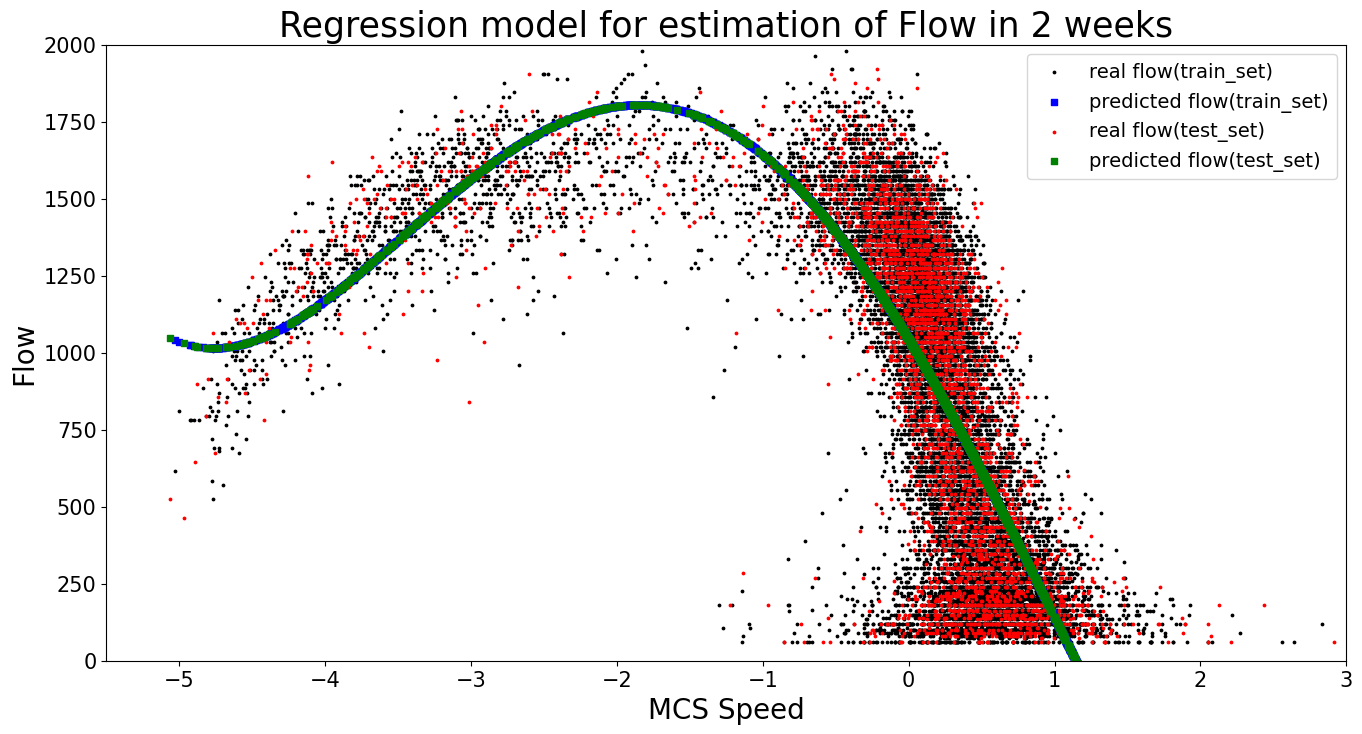

In [131]:
# Plot real and predicted flow for X_train, X_test
plt.figure(figsize=(16, 8))
plt.ylim(top = 2000)
plt.xlim(left=-5.5, right = 3)
plotResult(X_train[:, 1], Y_train, Y_predict_train, 
           X_test[:, 1], Y_test, Y_predict_test, '2 weeks', 'MCS Speed', 'Flow')

In [132]:
# Use all data to train and predict the flow
Y_predict = regressor.predict(X_features)
print("Root Mean Square Error: ", mean_squared_error(Y_label, Y_predict, squared=False))
print("R2 Score: ", r2_score(Y_label, Y_predict))

Root Mean Square Error:  343.8662259347639
R2 Score:  0.5493942580431579


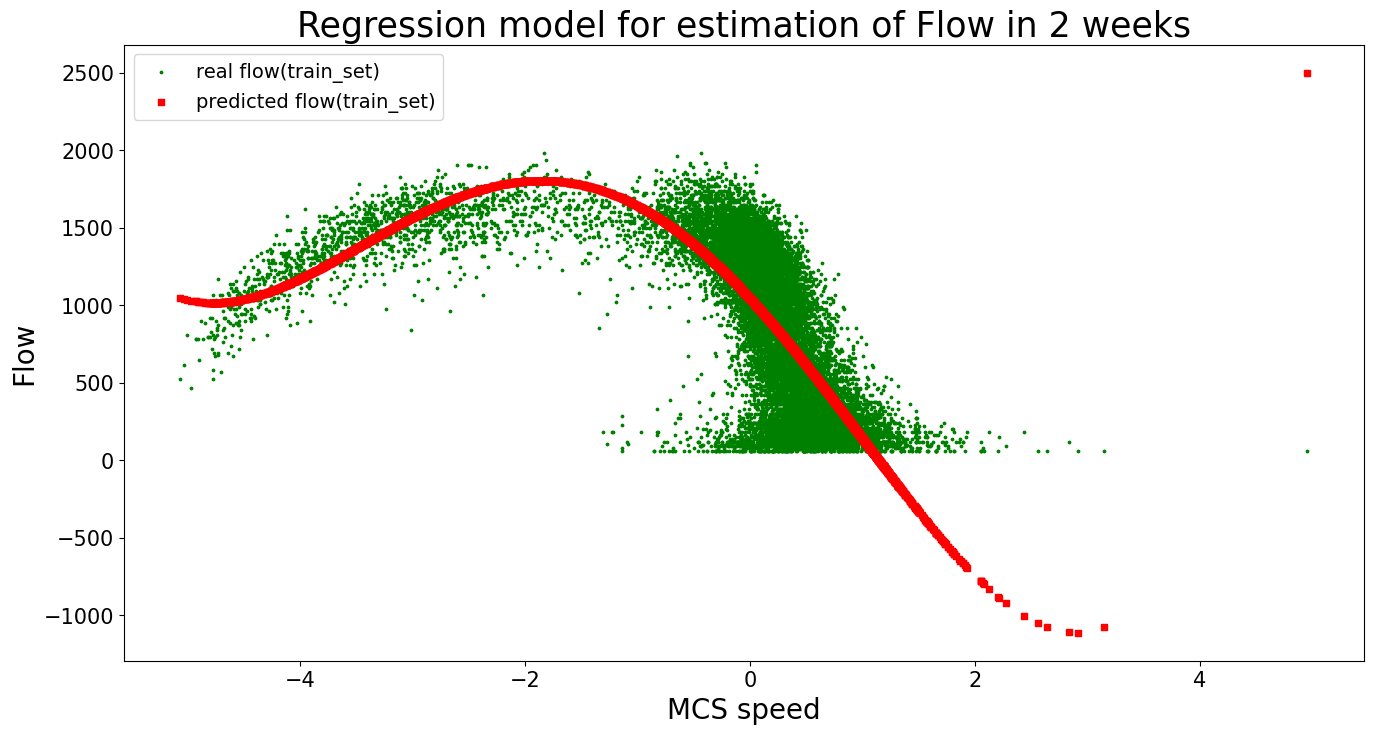

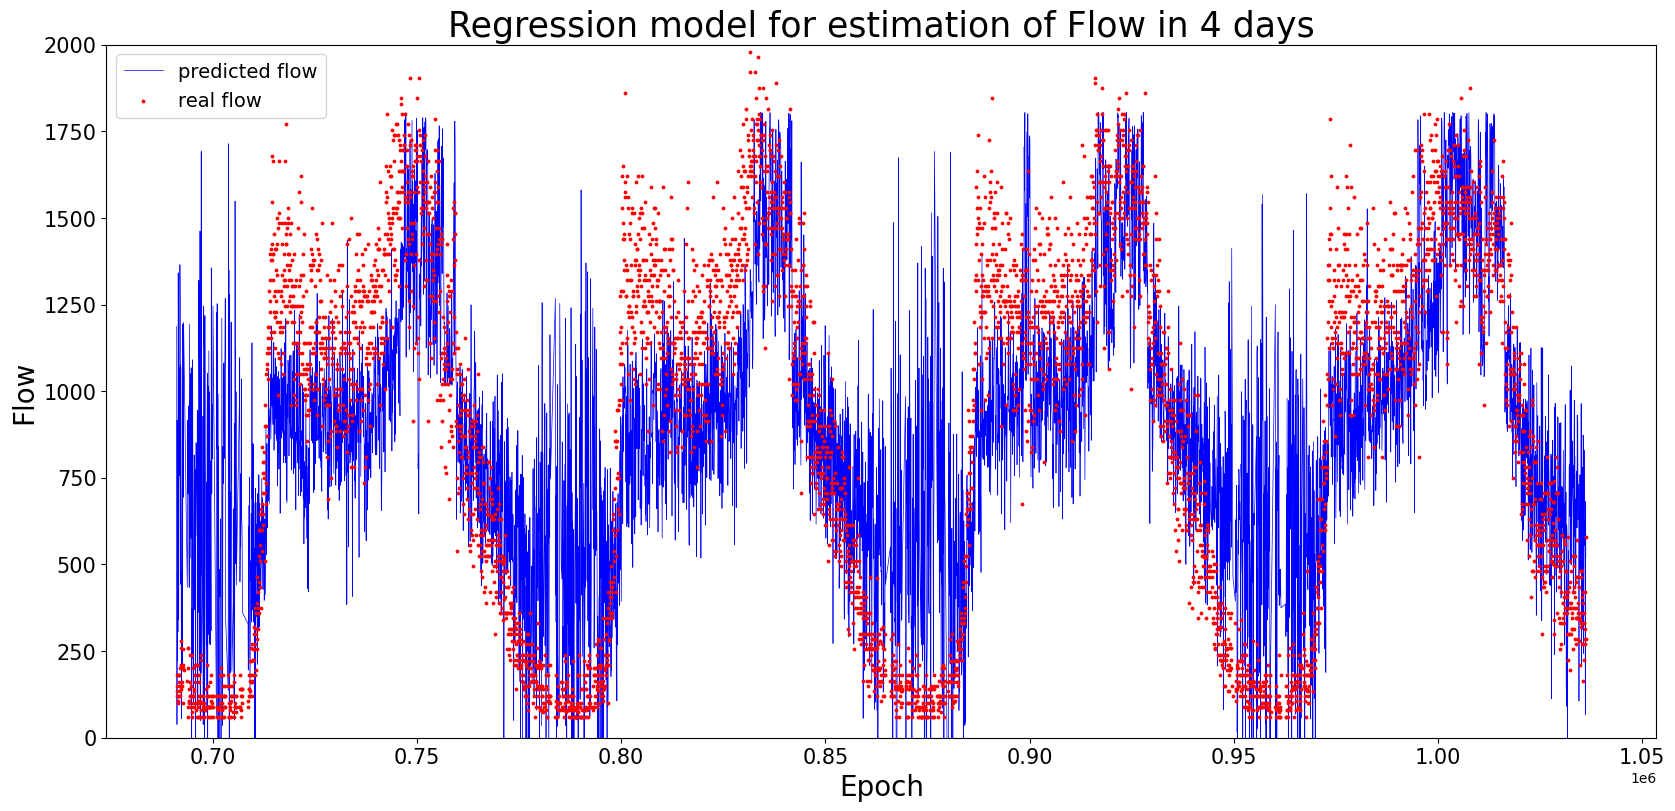

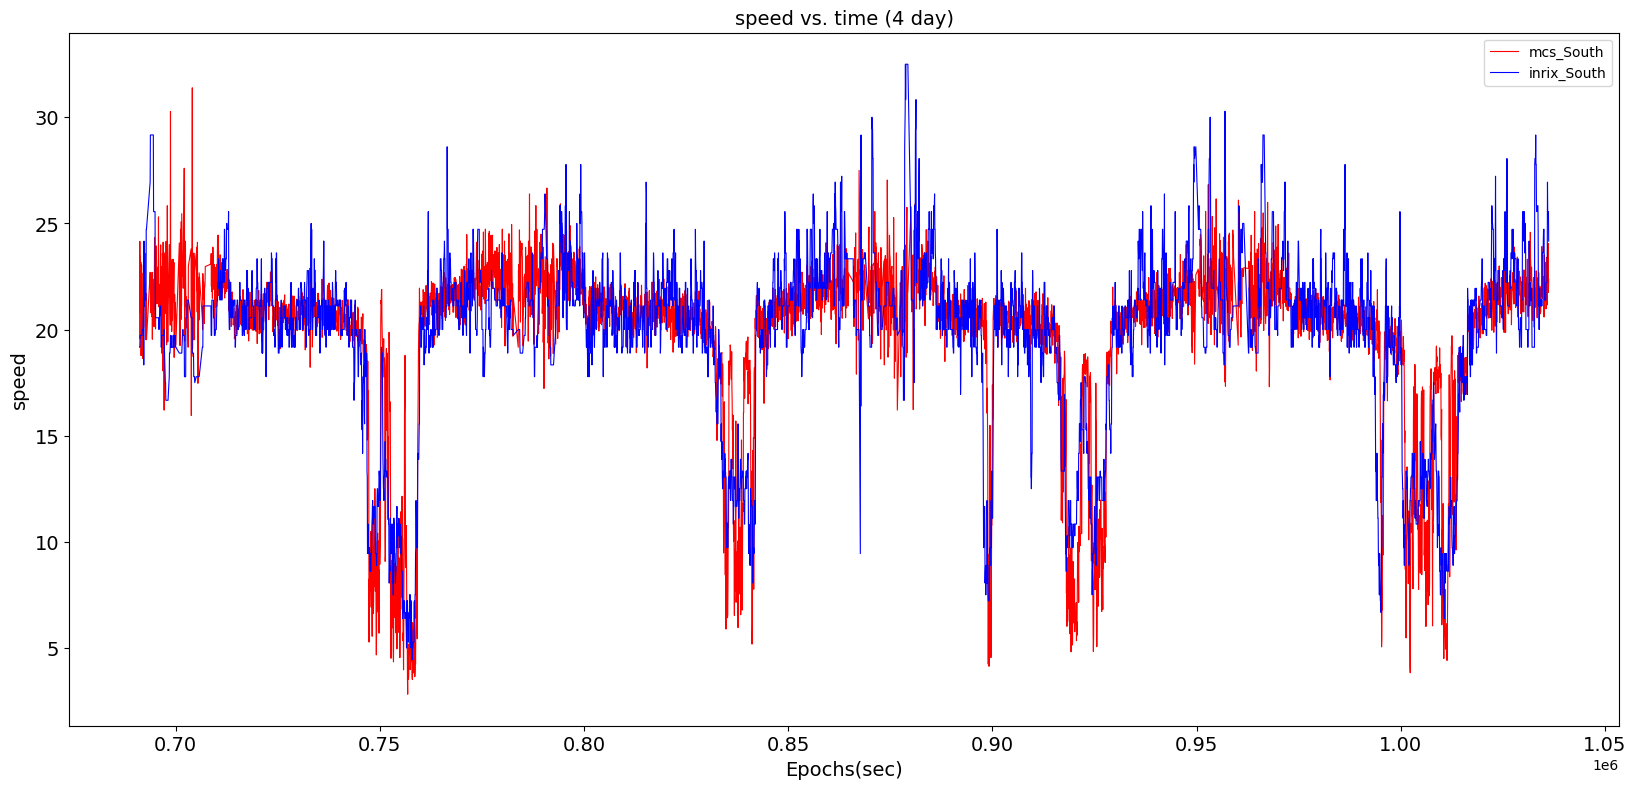

In [133]:
# Plot real and predicted flow vs. X_features (speed_mcs)
plt.figure(figsize=(16, 8))
plotResult(X_features[:, 1], Y_label, Y_predict, 
           None,  None, None, '2 weeks', 'MCS speed', 'Flow')

# Plot real and predicted flow vs. Epoch 
plt.figure(figsize=(20, 9))
plt.ylim(bottom = 0, top = 2000)
plotResult(X_epoch[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           Y_label[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           Y_predict[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           None, None, None, '4 days', 'Epoch', 'Flow', 'p')

# Plot corresponding mcs speed 
plt.figure(figsize=(20, 9))
plot2Attr(4, combinedSouth_2w.iloc[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)],'speed', 'speed_inrix', 'South')

# Plot corresponding inrix speed (display 3 days' data)
# inrixSouth3days = inrixSouth.iloc[:4312]
# plt.figure(figsize=(19, 9))
# plotAttr(3, inrixSouth3days, inrixSouth3days,'speed', 'inrix')'''

## 3.2 Linear regression model: INRIX Speed -> MCS Flow

In [236]:
# prepare the feature "INRIX speed"
X_inrix_speed = combinedSouth_2w['speed_inrix'].values
Y_flow = combinedSouth_2w['flow'].values

# turn single feature into polynomial features matrix: 1, s, s^2, s^3, ...
X_inrix_speed = makePoly(5, X_inrix_speed)
X_inrix_speed, scaler_mcs_speed = normalize(X_inrix_speed)


# code for monitoring feature matrix
# could be commented out while don't want to print out
dfRawFeatures = pd.DataFrame(X_inrix_speed)
dfRawFeatures.describe()

0             1  ...             4             5
count  18972.0  1.897200e+04  ...  1.897200e+04  1.897200e+04
mean       1.0 -1.977735e-13  ... -4.801280e-14 -4.880300e-15
std        0.0  1.000026e+00  ...  1.000026e+00  1.000026e+00
min        1.0 -4.551836e+00  ... -1.570084e+00 -1.185913e+00
25%        1.0 -2.144140e-01  ... -4.550873e-01 -4.541391e-01
50%        1.0  1.411124e-01  ... -1.061034e-01 -1.575177e-01
75%        1.0  4.255335e-01  ...  2.274002e-01  1.431512e-01
max        1.0  4.265219e+00  ...  1.258189e+01  1.633805e+01

[8 rows x 6 columns]

In [0]:
# assign normalized polynomial features matrix into feature matrix,
# assign predict target to label array
X_features = X_inrix_speed
Y_label = Y_flow

# split training and test data
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y_label, test_size=0.2, random_state=1)

In [238]:
# Build the regression model fitted on train dataset
regressor = LRmodel(X_train, Y_train)

# Evaluate Performance of training set
Y_predict_train = regressor.predict(X_train)
print("Root Mean Square Error for training set: ", mean_squared_error(Y_train, Y_predict_train, squared=False))
print("R2 Score for training set: ", r2_score(Y_train, Y_predict_train))

# Evaluate Performance of testing set
Y_predict_test = regressor.predict(X_test)
print("Root Mean Square Error: ", mean_squared_error(Y_test, Y_predict_test, squared=False))
print("R2 Score: ", r2_score(Y_test, Y_predict_test))

Root Mean Square Error for training set:  427.97901022294815
R2 Score for training set:  0.30166241865960286
Root Mean Square Error:  420.8433081857461
R2 Score:  0.326321752132687


    R2 Experiment:
    * d = 2: (0.28, 0.30)
    * d = 3: (0.30, 0.32)
    * d = 4: (0.30, 0.32)
    * d = 5: (0.30, 0.326)
    * d = 6: (0.30, 0.326)

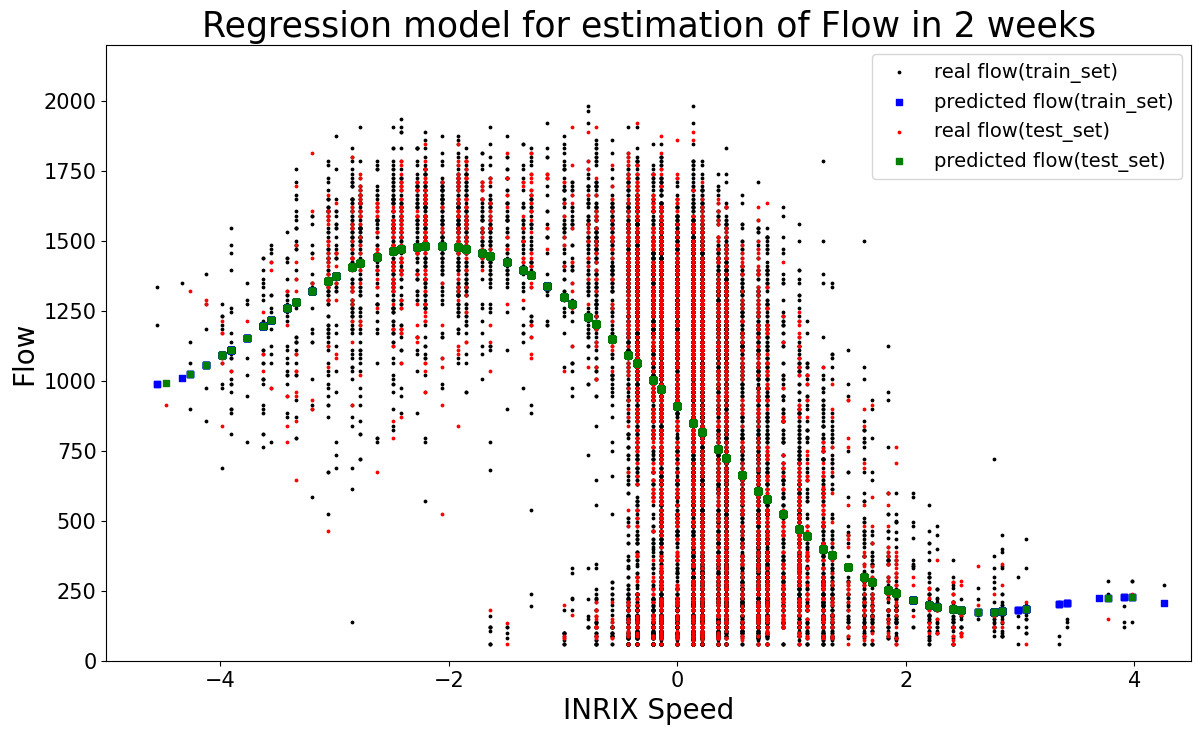

In [242]:
# Plot real and predicted flow for X_train, X_test
plt.figure(figsize=(14, 8))
plt.ylim(top = 2200)
plt.xlim(left=-5, right = 4.5)
plotResult(X_train[:, 1], Y_train, Y_predict_train, 
           X_test[:, 1], Y_test, Y_predict_test, '2 weeks', 'INRIX Speed', 'Flow')

In [240]:
# Use all dataset to train and predict the flow
Y_predict = regressor.predict(X_features)
print("Root Mean Square Error: ", mean_squared_error(Y_label, Y_predict, squared=False))
print("R2 Score: ", r2_score(Y_label, Y_predict))

Root Mean Square Error:  426.5611949156848
R2 Score:  0.3066055424404327


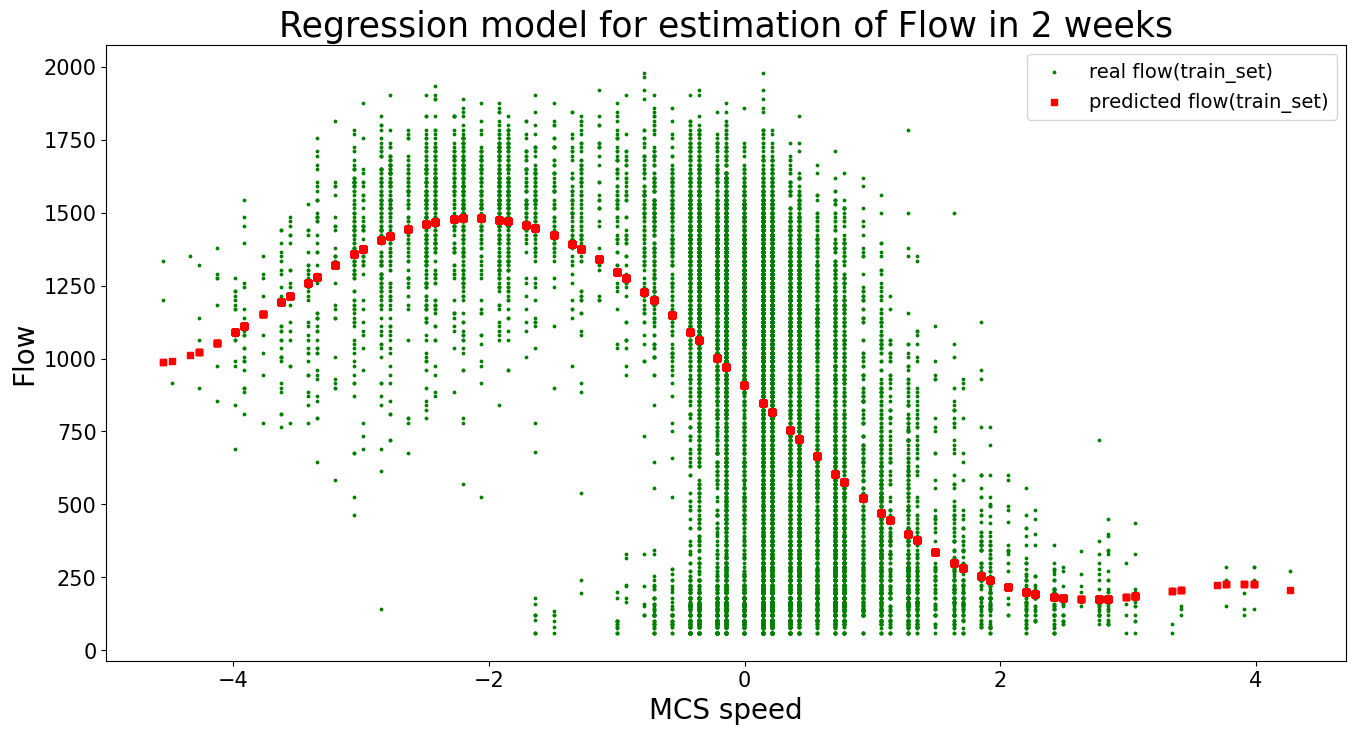

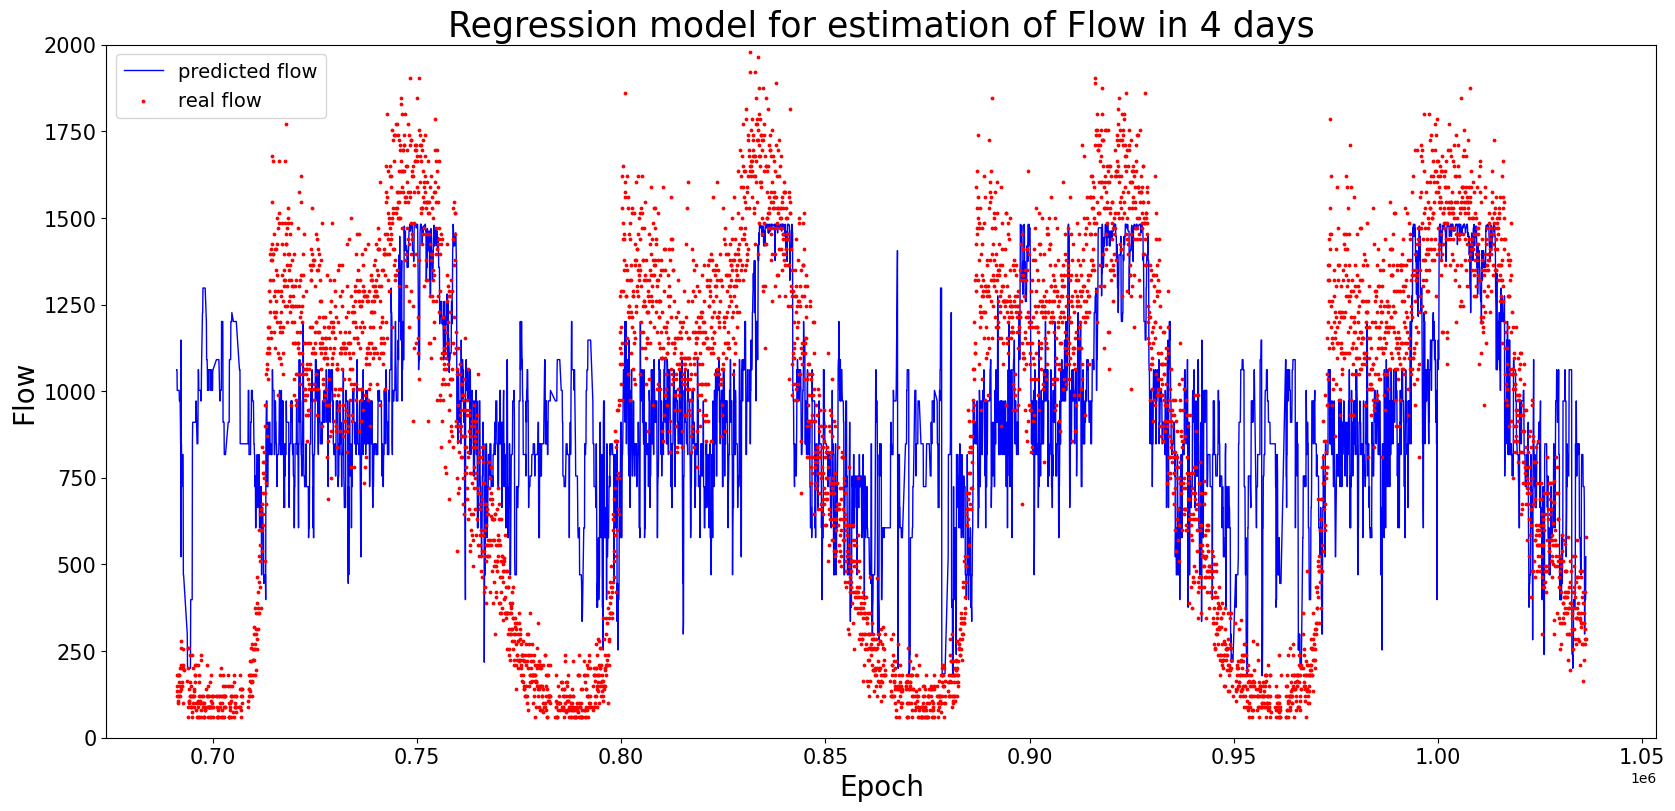

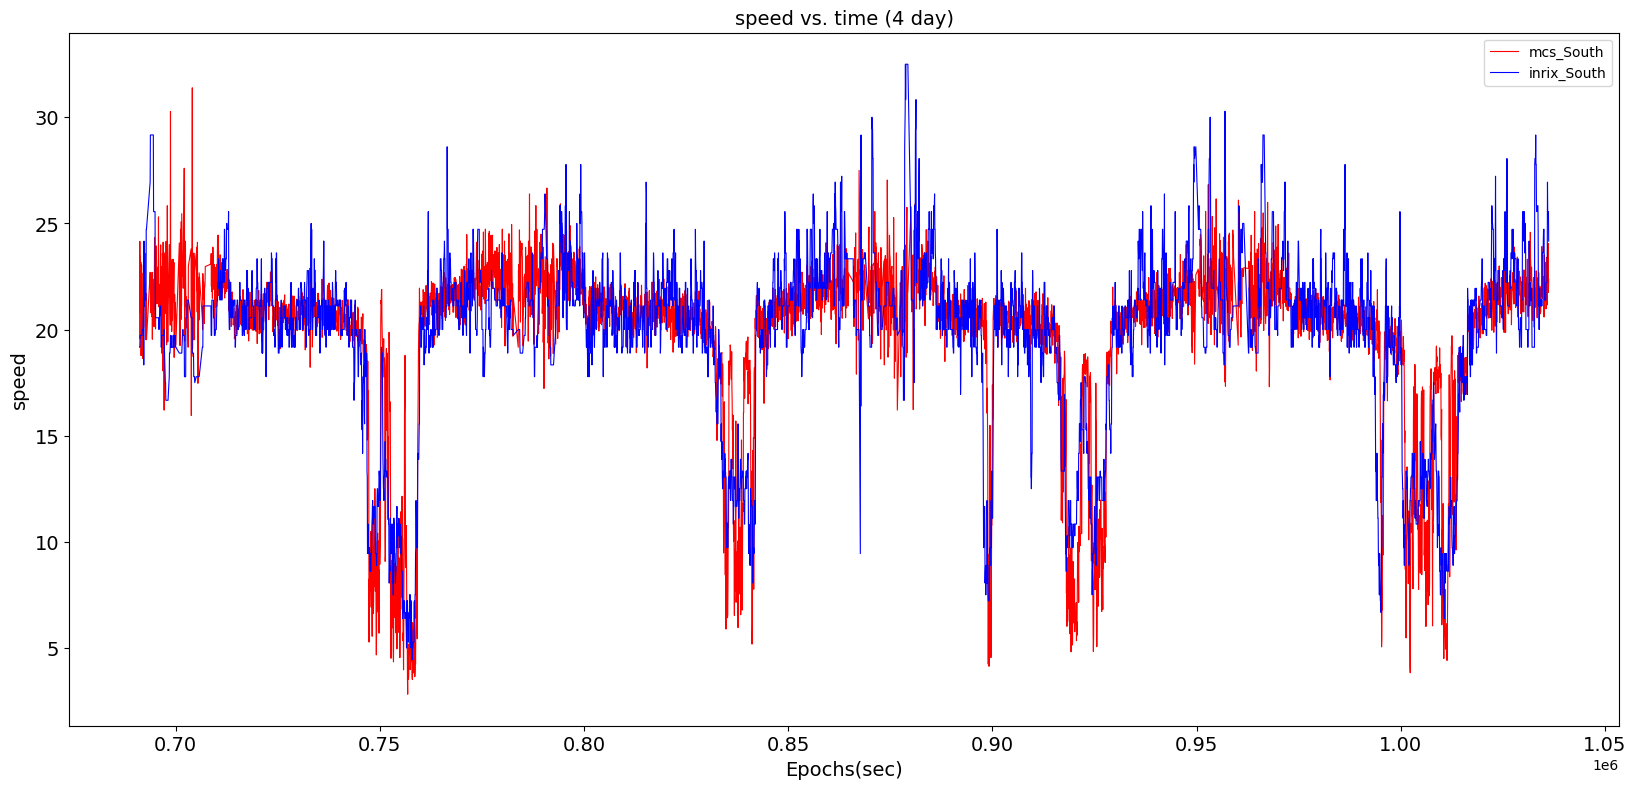

In [241]:
# Plot real and predicted flow vs. X_features (speed_mcs)
plt.figure(figsize=(16, 8))
plotResult(X_features[:, 1], Y_label, Y_predict, 
           None,  None, None, '2 weeks', 'MCS speed', 'Flow')

# Plot real and predicted flow vs. Epoch 
plt.figure(figsize=(20, 9))
plt.ylim(bottom = 0, top = 2000)
plotResult(X_epoch[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           Y_label[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           Y_predict[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           None, None, None, '4 days', 'Epoch', 'Flow', 'p')

# Plot corresponding mcs speed 
plt.figure(figsize=(20, 9))
plot2Attr(4, combinedSouth_2w.iloc[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)],'speed', 'speed_inrix', 'South')

# Plot corresponding inrix speed (display 3 days' data)
# inrixSouth3days = inrixSouth.iloc[:4312]
# plt.figure(figsize=(19, 9))
# plotAttr(3, inrixSouth3days, inrixSouth3days,'speed', 'inrix')'''

# 4. Dicision Tree


*   Use decision tree to extract dependency between MCS speed and (MCS) flow
*   Use decision tree to extract dependency between INRIX speed, INRIX travel time and (MCS) flow



## 4.1 Decision tree model: MCS speed -> MCS flow



In [0]:
# function for quickly tuning the depth of the decision tree 
# (should use cross validation for hyper-parameter tuning)
# Input: decision tree model, train and test datasets, and a list that specifies the 
# depth splits, eg: split = [2, 3, 4, 5, 6] tests depth from 2 to 6
# Output: return the experiment result in as dataframe with 3 columns:
# depth split, r2 for test dataset, r2 for train dataset.
def quickSplitTuning(model, x_train, y_train, x_test, y_test, split):
  trainR2Array = []
  testR2Array = []
  for i in split:
    estimator = model(max_depth = i, random_state = 0)
    estimator.fit(x_train, y_train)
    trainR2Array.append(estimator.score(x_train, y_train))
    testR2Array.append(estimator.score(x_test, y_test))
  result = pd.DataFrame({'split': split, 'Train_R2': trainR2Array, 'Test_R2': testR2Array})
  
  return result


In [256]:
# prepare the features [MCS speed] and label [flow]
# Notice: Y_flow was already defined in previous section 3.
# X_epoch was already defined
X_mcs_speed = combinedSouth_2w['speed'].values.reshape(-1, 1)

X_features = X_mcs_speed
Y_label = Y_flow

print(X_features.shape)

# split the train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y_label, test_size=0.2, random_state=1)


(18972, 1)


In [257]:
# temporarily tune the max_depth (hyperparameters) 
split = list(range(1, 15))
print(split)
result = quickSplitTuning(DecisionTreeRegressor, X_train, Y_train, X_test, Y_test, split)
print(result)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    split  Train_R2   Test_R2
0       1  0.447755  0.450623
1       2  0.551072  0.561087
2       3  0.577913  0.588054
3       4  0.592121  0.594406
4       5  0.599223  0.598586
5       6  0.603988  0.597108
6       7  0.609141  0.593770
7       8  0.616088  0.587177
8       9  0.627288  0.580173
9      10  0.641348  0.562611
10     11  0.654833  0.557436
11     12  0.670798  0.537428
12     13  0.687255  0.517059
13     14  0.703701  0.499634


    Split Experiment Result:
    depth = 5 or 6 has largest accuracy while not over-fitting

In [258]:
# train the model with train dataset and check the accuracy
DT_MAXDEPTH = 6
DTRegressor = DecisionTreeRegressor(max_depth = DT_MAXDEPTH, random_state=0)
DTRegressor.fit(X_train, Y_train)

# Evaluate Performance of training set
Y_predict_train = DTRegressor.predict(X_train)
print("Root Mean Square Error: ", mean_squared_error(Y_train, Y_predict_train, squared=False))
print("R2 Score: ", DTRegressor.score(X_train, Y_train))

# Evaluate Performance of testing set
Y_predict_test = DTRegressor.predict(X_test)
print("Root Mean Square Error: ", mean_squared_error(Y_test, Y_predict_test, squared=False))
print("R2 Score: ", r2_score(Y_test, Y_predict_test))


Root Mean Square Error:  322.28798583688933
R2 Score:  0.6039876709923077
Root Mean Square Error:  325.4532552599774
R2 Score:  0.5971077506538804


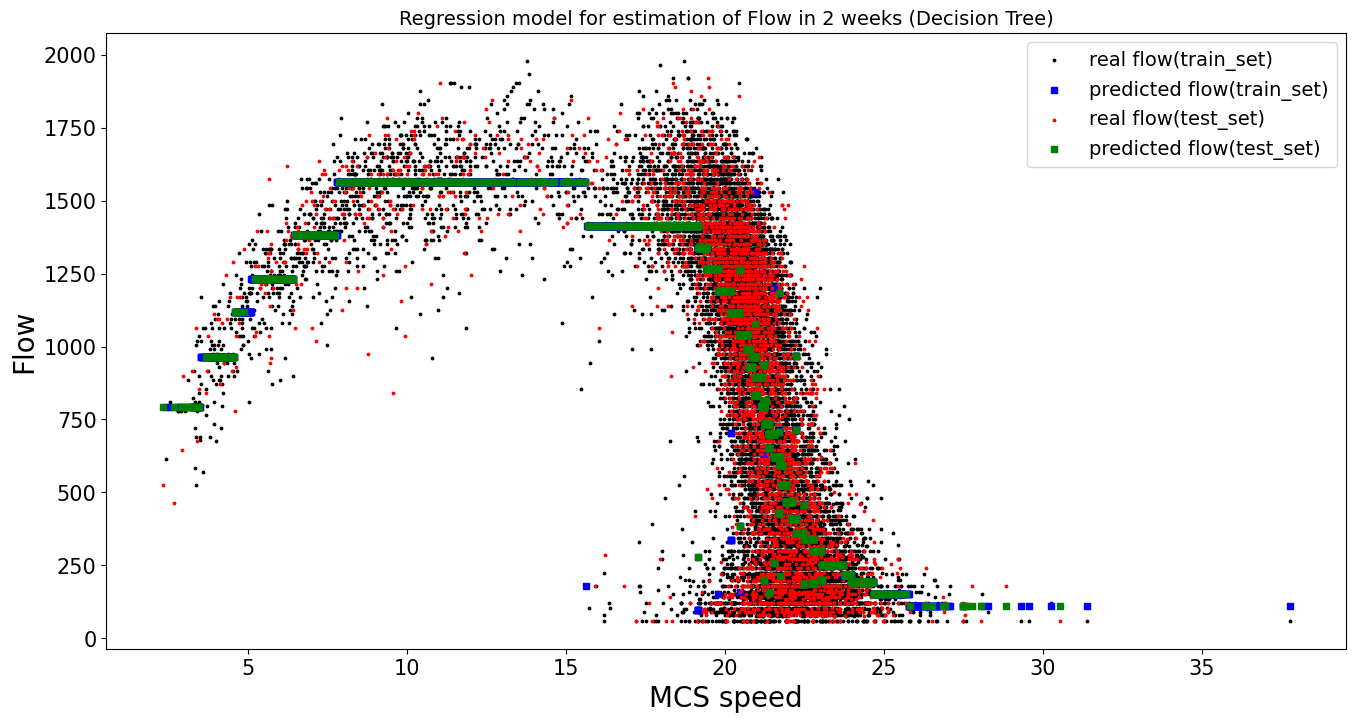

In [259]:
# Plot real and predicted 'flow' vs 'mcs speed' 
plt.figure(figsize=(16, 8))
# plt.ylim(top = 2000)
plotResult(X_train[:, 0], Y_train, Y_predict_train, X_test[:, 0], Y_test, Y_predict_test, '2 weeks (Decision Tree)', 'MCS speed', 'Flow')


In [260]:
# Use all data to predict the flow
# DTRegressor.fit(X_features, Y_label)
Y_predict = DTRegressor.predict(X_features)
print("Root Mean Square Error: ", mean_squared_error(Y_label, Y_predict, squared=False))
print("R2 Score: ", r2_score(Y_label, Y_predict))

Root Mean Square Error:  322.92362218456736
R2 Score:  0.6026096581745147


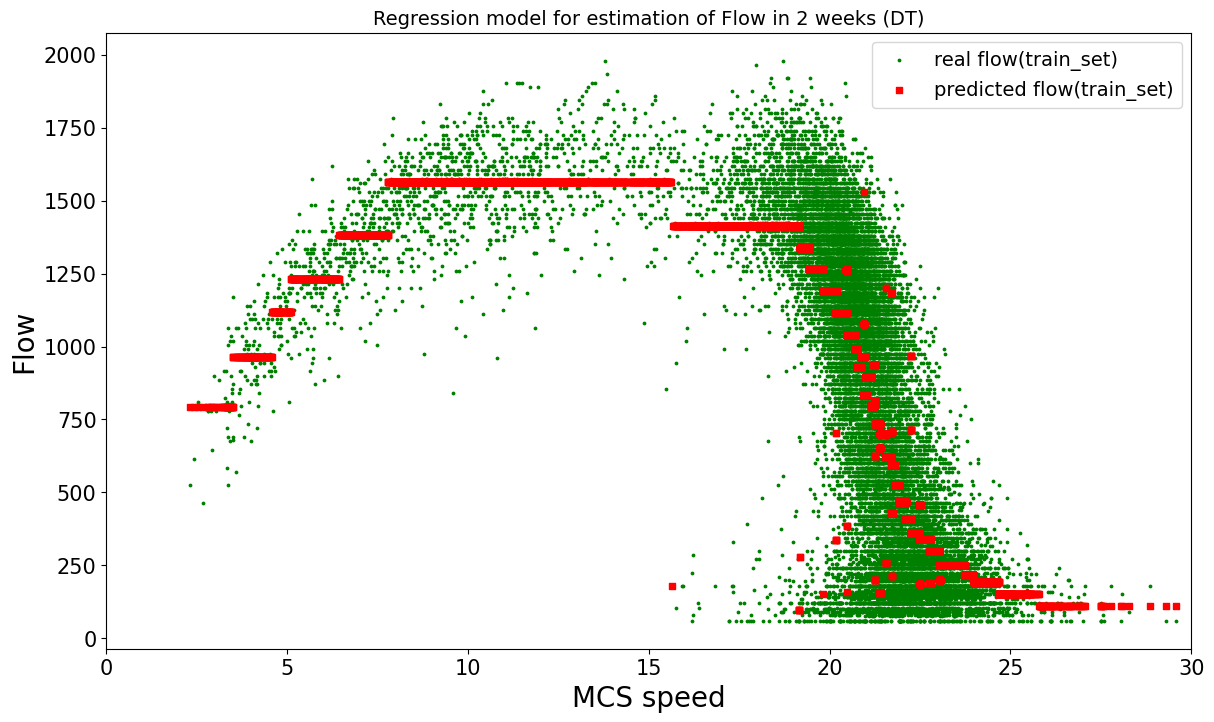

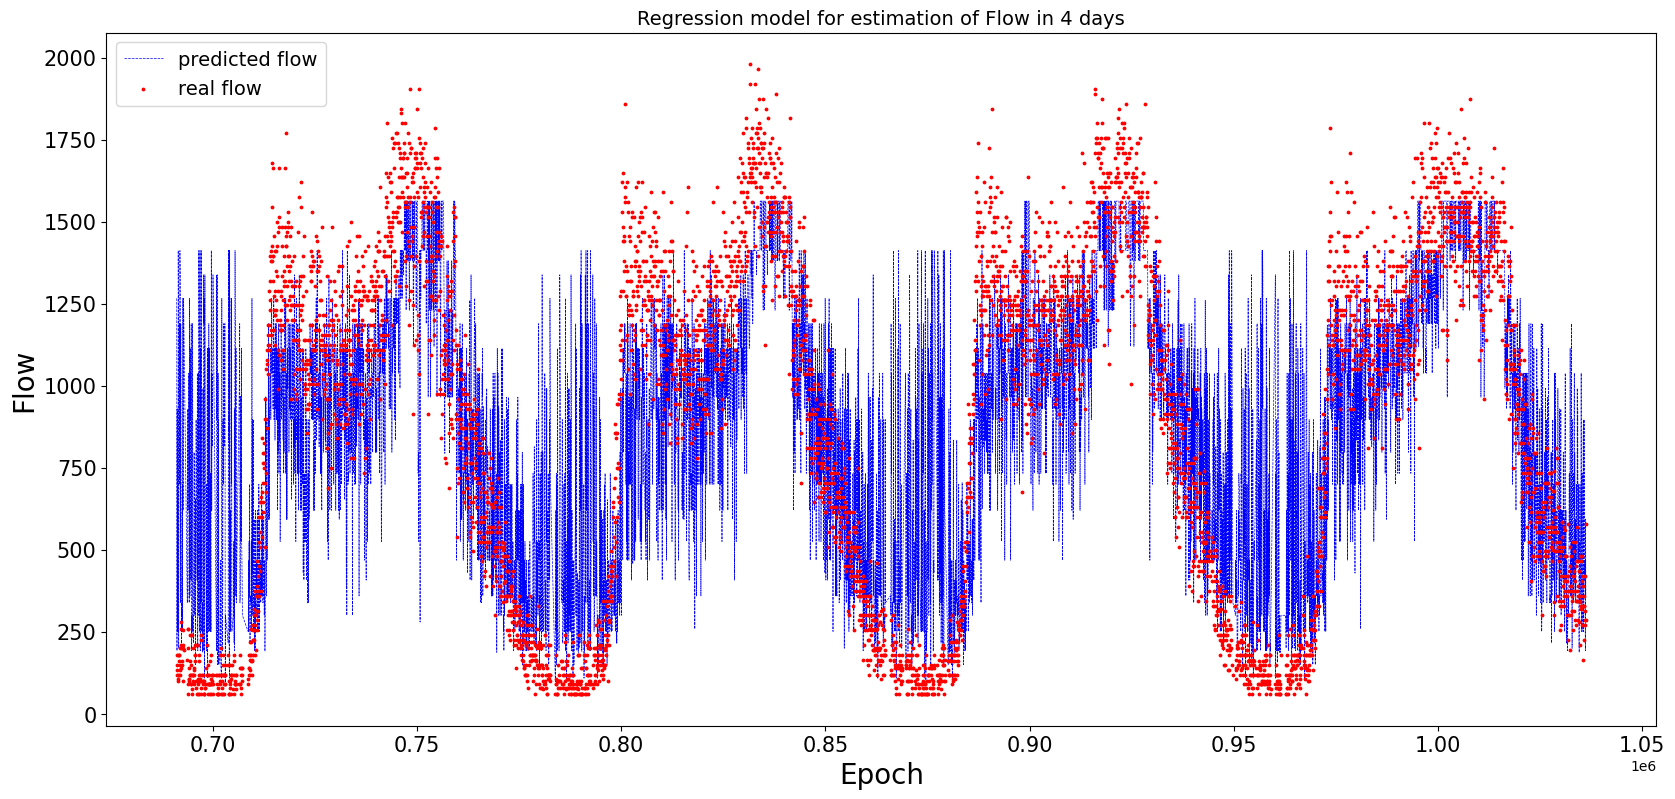

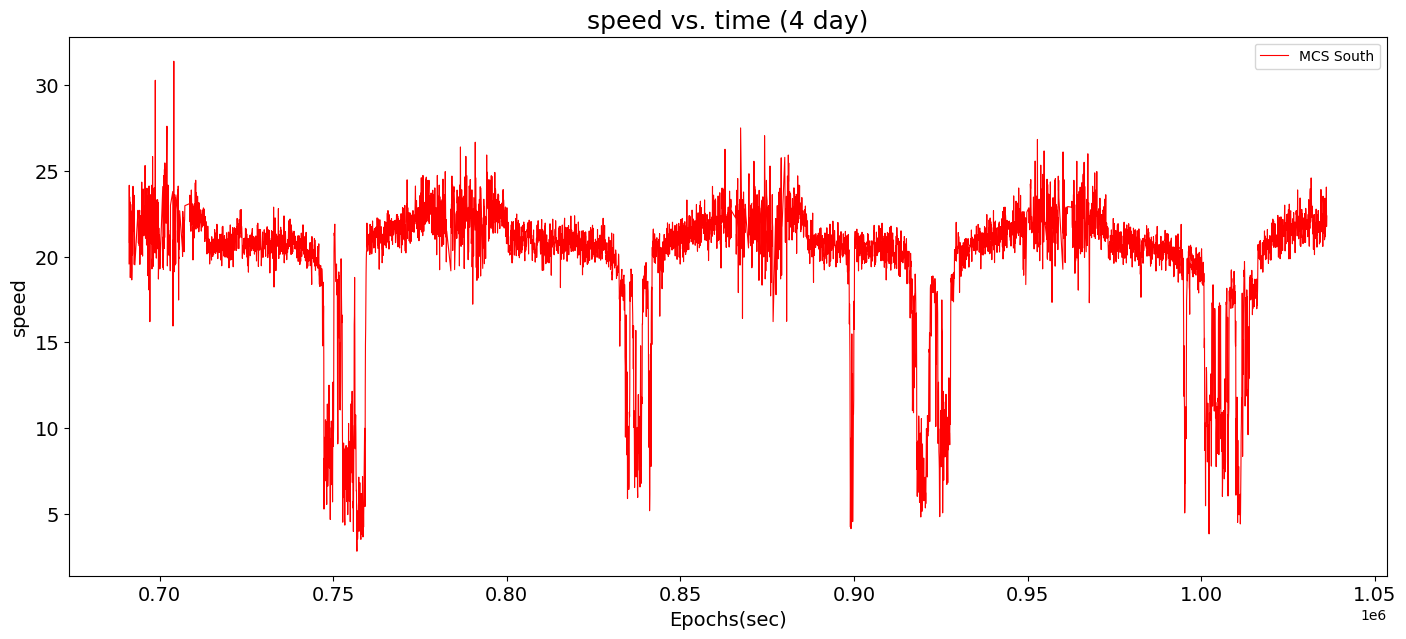

In [266]:
# Plot real and predicted flow vs. X_features (speed_mcs)
plt.figure(figsize=(14, 8))
plt.xlim(right = 30)
plotResult(X_features[:, 0], Y_label, Y_predict, 
           None,  None, None, '2 weeks (DT)', 'MCS speed', 'Flow')

# Plot real and predicted flow vs. Epoch 
plt.figure(figsize=(20, 9))
# plt.ylim(bottom = 0, top = 2000)
plotResult(X_epoch[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           Y_label[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           Y_predict[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           None, None, None, '4 days', 'Epoch', 'Flow', 'p')

# Plot corresponding mcs speed 
plt.figure(figsize=(17, 7))
plotAttr(4, combinedSouth_2w.iloc[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 'speed', 'MCS South')



# Plot corresponding inrix speed (display 3 days' data)
# inrixSouth3days = inrixSouth.iloc[:4312]
# plt.figure(figsize=(19, 9))
# plotAttr(3, inrixSouth3days, inrixSouth3days,'speed', 'inrix')'''

## 4.2 Decision tree model: INRIX speed & Travel Time -> MCS flow



In [245]:
# prepare the features [MCS speed] and label [flow]
# Notice: Y_flow was already defined in previous section 3.
# X_epoch was already defined
X_inrix_speed_travelTime = combinedSouth_2w[['speed_inrix', 'travel_time_secs']].values

X_features = X_inrix_speed_travelTime
Y_label = Y_flow

print(X_features.shape)

# split the train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y_label, test_size=0.2, random_state=1)

(18972, 2)


In [246]:
# temporarily tune the max_depth (hyperparameters) 
# Notice: should use cross-validation instead, here only for quick result
split = list(range(1, 15))
print(split)
result = quickSplitTuning(DecisionTreeRegressor, X_train, Y_train, X_test, Y_test, split)
print(result)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    split  Train_R2   Test_R2
0       1  0.173279  0.196749
1       2  0.288119  0.313021
2       3  0.303041  0.326638
3       4  0.307948  0.332237
4       5  0.309369  0.333545
5       6  0.310436  0.333026
6       7  0.311042  0.332932
7       8  0.311233  0.332918
8       9  0.311317  0.332677
9      10  0.311357  0.332836
10     11  0.311377  0.332741
11     12  0.311388  0.332736
12     13  0.311388  0.332736
13     14  0.311388  0.332736


    Tree Depth split reslut:
    d = 5 or 6 has highest r2 value while not over-fitting

In [247]:
# train the model with train dataset and check the accuracy
DT_MAXDEPTH = 5
DTRegressor = DecisionTreeRegressor(max_depth = DT_MAXDEPTH, random_state=0)
DTRegressor.fit(X_train, Y_train)

# Evaluate Performance of training set
Y_predict_train = DTRegressor.predict(X_train)
print("Root Mean Square Error: ", mean_squared_error(Y_train, Y_predict_train, squared=False))
print("R2 Score: ", DTRegressor.score(X_train, Y_train))

# Evaluate Performance of testing set
Y_predict_test = DTRegressor.predict(X_test)
print("Root Mean Square Error: ", mean_squared_error(Y_test, Y_predict_test, squared=False))
print("R2 Score: ", r2_score(Y_test, Y_predict_test))


Root Mean Square Error:  425.6109564976375
R2 Score:  0.3093689922038697
Root Mean Square Error:  418.5810114354393
R2 Score:  0.33354517088173685


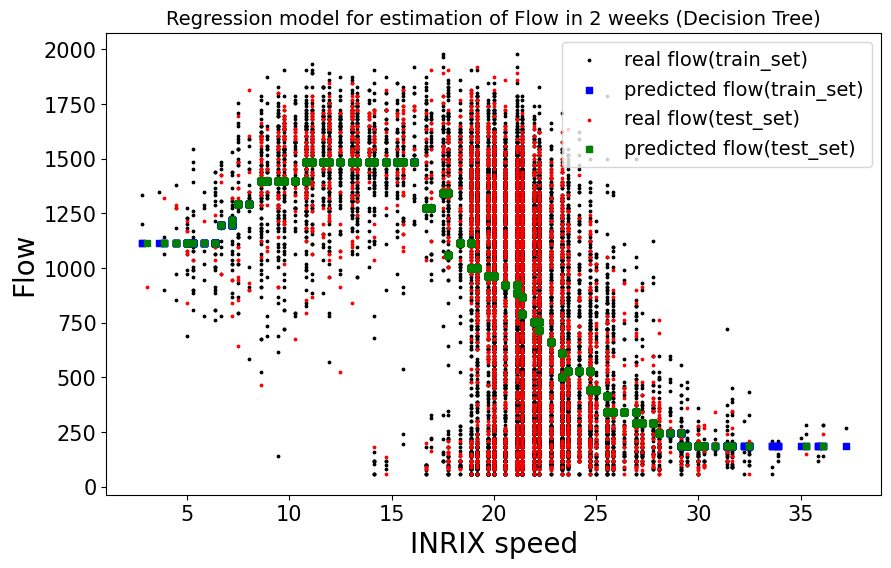

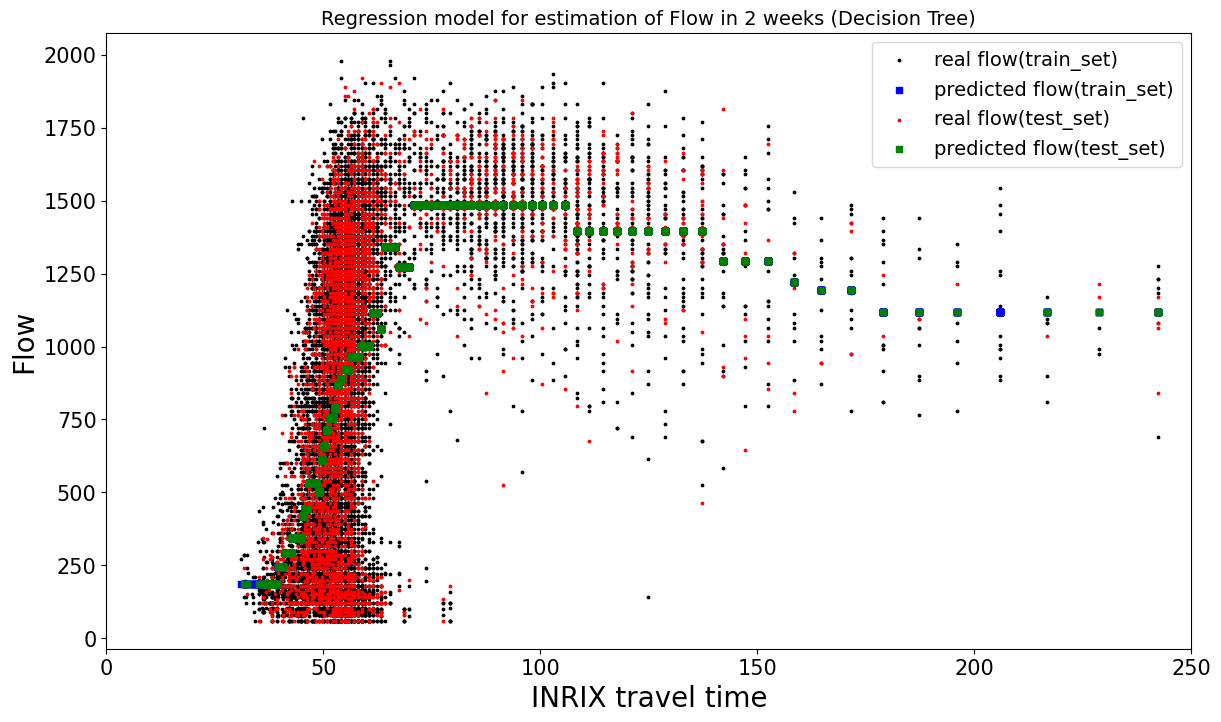

In [248]:
# Plot real and predicted 'flow' vs 'speed' 
plt.figure(figsize=(10, 6))
# plt.ylim(top = 2000)
plotResult(X_train[:, 0], Y_train, Y_predict_train, X_test[:, 0], Y_test, Y_predict_test, '2 weeks (Decision Tree)', 'INRIX speed', 'Flow')

# Plot real and predicted 'flow' vs 'speed' 
plt.figure(figsize=(14, 8))
plt.xlim(right = 250)
plotResult(X_train[:, 1], Y_train, Y_predict_train, X_test[:, 1], Y_test, Y_predict_test, '2 weeks (Decision Tree)', 'INRIX travel time', 'Flow')

In [249]:
# Use all data to predict the flow
# DTRegressor.fit(X_features, Y_label)
Y_predict = DTRegressor.predict(X_features)
print("Root Mean Square Error: ", mean_squared_error(Y_label, Y_predict, squared=False))
print("R2 Score: ", r2_score(Y_label, Y_predict))

Root Mean Square Error:  424.21406621396744
R2 Score:  0.31421527571037144


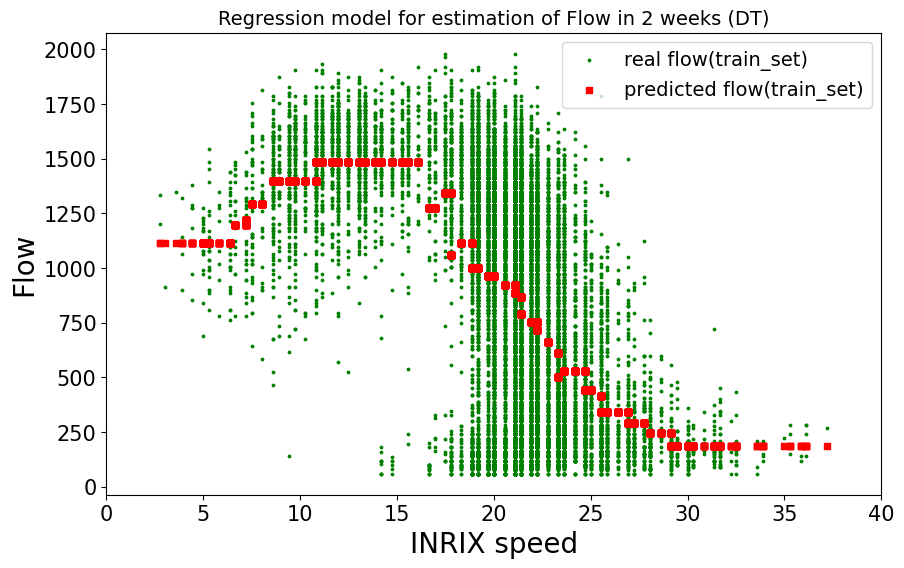

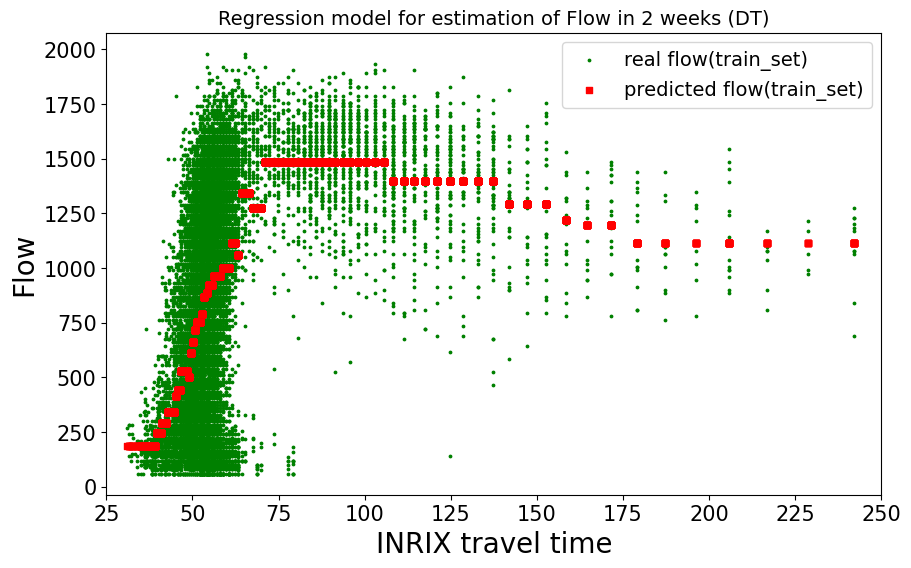

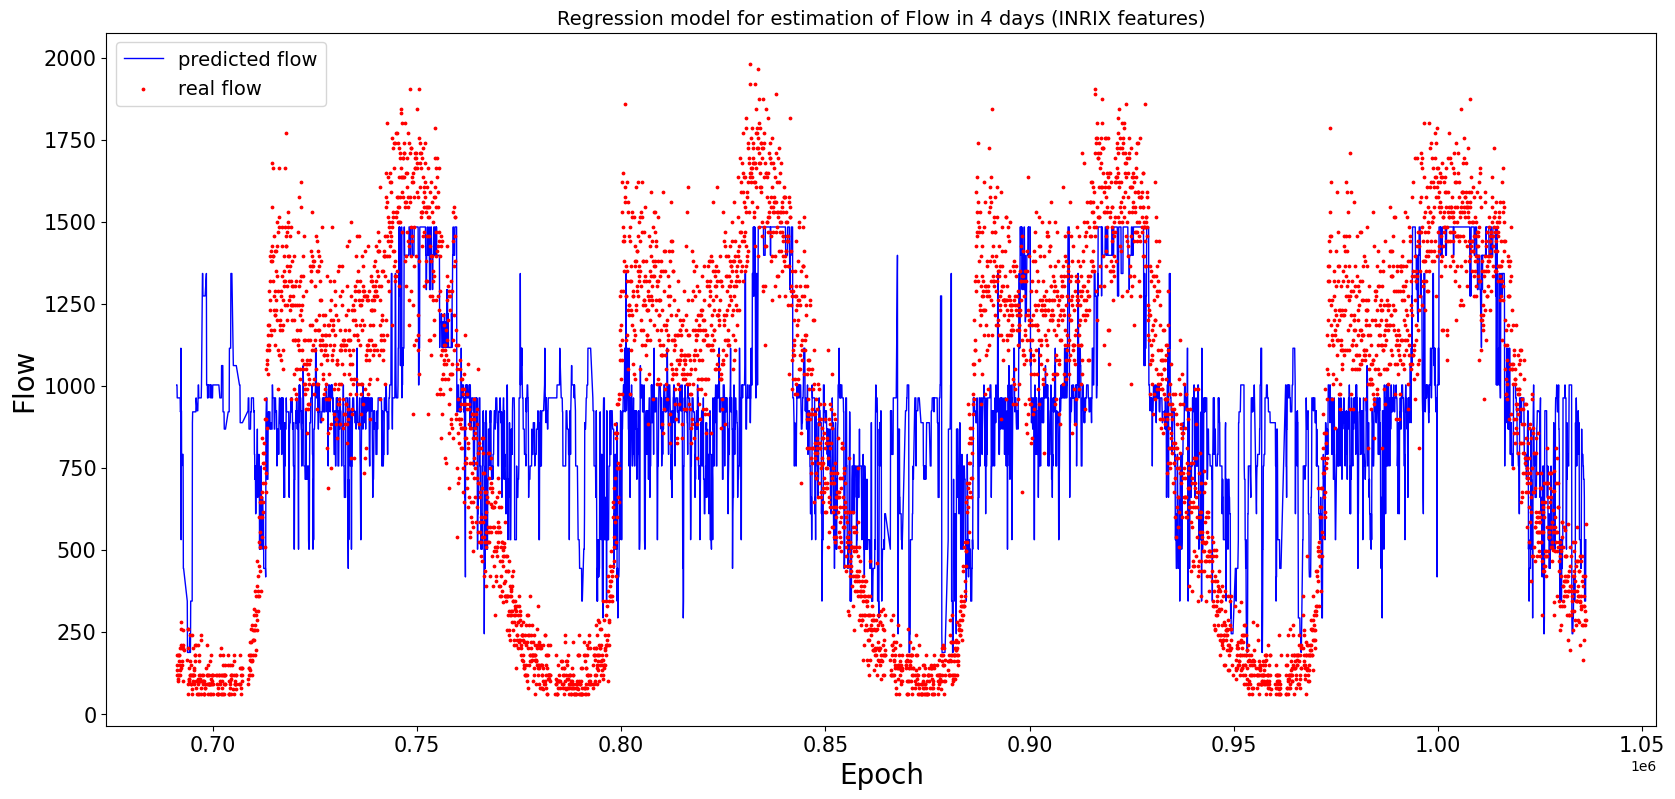

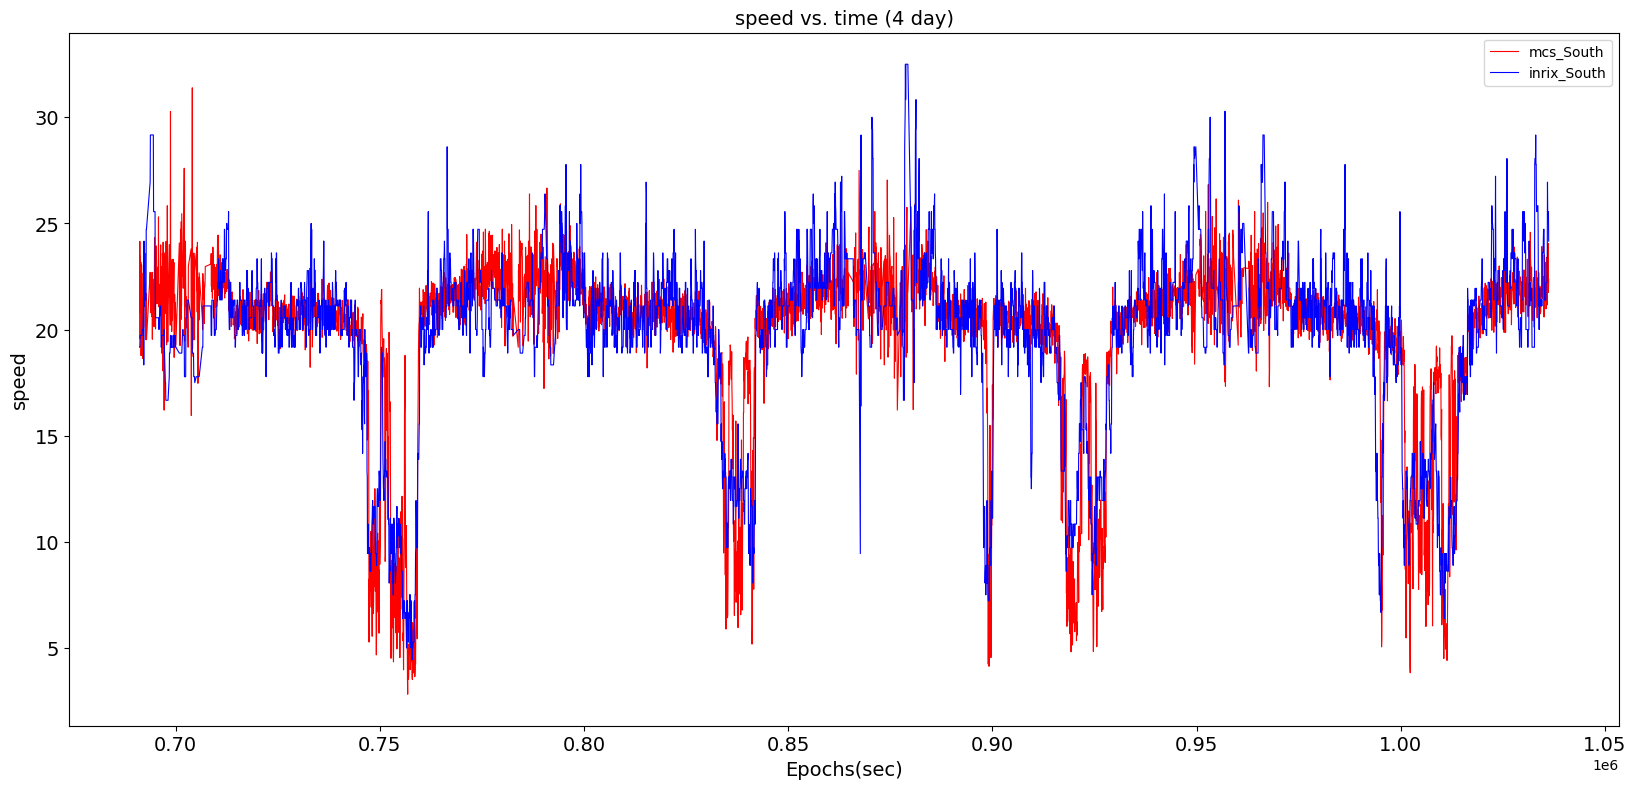

In [250]:
# Plot real and predicted flow vs. X_features (speed)
plt.figure(figsize=(10, 6))
plt.xlim(right = 40)
plotResult(X_features[:, 0], Y_label, Y_predict, 
           None,  None, None, '2 weeks (DT)', 'INRIX speed', 'Flow')

# Plot real and predicted flow vs. X_features (travel time)
plt.figure(figsize=(10, 6))
plt.xlim(left= 25, right = 250)
plotResult(X_features[:, 1], Y_label, Y_predict, 
           None,  None, None, '2 weeks (DT)', 'INRIX travel time', 'Flow')

# Plot real and predicted flow vs. Epoch 
plt.figure(figsize=(20, 9))
# plt.ylim(bottom = 0, top = 2000)
plotResult(X_epoch[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           Y_label[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           Y_predict[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           None, None, None, '4 days (INRIX features)', 'Epoch', 'Flow', 'p')

# Plot corresponding mcs & inrix speed 
plt.figure(figsize=(20, 9))
plot2Attr(4, combinedSouth_2w.iloc[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)],'speed', 'speed_inrix', 'South')

# Plot corresponding inrix speed (display 3 days' data)
# inrixSouth3days = inrixSouth.iloc[:4312]
# plt.figure(figsize=(19, 9))
# plotAttr(3, inrixSouth3days, inrixSouth3days,'speed', 'inrix')'''

# 5. Random Forest